In [1]:
from easy_diffusion.ddim.diffusion import Diffusion

from easy_diffusion.base_model import UNet_Tranformer, UNet_Tranformer_Arch
from easy_diffusion.base_model import marginal_prob_std_fn,diffusion_coeff_fn
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
import os

from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

Available models: ['ViT-B-16', 'ViT-L-14', 'ViT-L-14-336', 'ViT-H-14', 'RN50']
Loading vision model config from /home/sysadmin/tangdong/workspace/anaconda3/envs/cn_image_generation/lib/python3.6/site-packages/cn_clip/clip/model_configs/ViT-B-16.json
Loading text model config from /home/sysadmin/tangdong/workspace/anaconda3/envs/cn_image_generation/lib/python3.6/site-packages/cn_clip/clip/model_configs/RoBERTa-wwm-ext-base-chinese.json
Model info {'embed_dim': 512, 'image_resolution': 224, 'vision_layers': 12, 'vision_width': 768, 'vision_patch_size': 16, 'vocab_size': 21128, 'text_attention_probs_dropout_prob': 0.1, 'text_hidden_act': 'gelu', 'text_hidden_dropout_prob': 0.1, 'text_hidden_size': 768, 'text_initializer_range': 0.02, 'text_intermediate_size': 3072, 'text_max_position_embeddings': 512, 'text_num_attention_heads': 12, 'text_num_hidden_layers': 12, 'text_type_vocab_size': 2}


In [2]:
seed = 999
# 没有使用GPU的时候设置的固定生成的随机数
np.random.seed(seed)
# 为CPU设置种子用于生成随机数，以使得结果是确定的
torch.manual_seed(seed)
# torch.cuda.manual_seed()为当前GPU设置随机种子
torch.cuda.manual_seed(seed)


In [3]:
from easy_diffusion.loss import loss_fn_cond
from easy_diffusion.utils import visualize_digit_embedding, save_samples_cond
from easy_diffusion.sample import Euler_Maruyama_sampler

In [4]:
image_shape = (1,32,32)
device = torch.device('cuda')

In [5]:
## Load the pre-trained checkpoint from disk.
# device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
# ckpt = torch.load('ckpt.pth', map_location=device)
# score_model.load_state_dict(ckpt)
def visual_process(score_model):
    num = np.random.randint(0,10)
    digit = num #@param {'type':'integer'}
    sample_batch_size = 64 #@param {'type':'integer'}
    num_steps = 250 #@param {'type':'integer'}
    sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
    # score_model.eval()
    ## Generate samples using the specified sampler.
    samples = sampler(score_model, 
        marginal_prob_std_fn,
        diffusion_coeff_fn, 
        sample_batch_size, 
        num_steps=num_steps,
        device=device,
        x_shape=image_shape,
        y=digit*torch.ones(sample_batch_size, dtype=torch.long))

    ## Sample visualization.
    samples = samples.clamp(0.0, 1.0)
    %matplotlib inline
    import matplotlib.pyplot as plt
    sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    plt.show()

In [6]:
#@title A handy training function
def train_diffusion_model(dataset,
                          score_model,
                          n_epochs =   100,
                          batch_size =  1024,
                          lr=10e-4,
                          model_name="transformer"):

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())

    optimizer = Adam(score_model.parameters(), lr=lr)
    scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.1, 0.96 ** epoch))
    tqdm_epoch = trange(n_epochs)
    for epoch in tqdm_epoch:
        score_model.train()
        avg_loss = 0.
        num_items = 0
        for x, y in tqdm(data_loader):
            x = x.to(device)    
            loss = loss_fn_cond(score_model, x, y, marginal_prob_std_fn)
            optimizer.zero_grad()
            loss.backward()    
            optimizer.step()
            avg_loss += loss.item() * x.shape[0]
            num_items += x.shape[0]
        scheduler.step()
        lr_current = scheduler.get_last_lr()[0]
        print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
        # Print the averaged training loss so far.
        tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
        # Update the checkpoint after each epoch of training.
        if not os.path.exists(os.path.join("model",model_name)):
            os.makedirs(os.path.join("model", model_name))
        model_path = os.path.join("model", model_name, f'ckpt_{model_name}.pth')
        torch.save(score_model.state_dict(), model_path)
        score_model.eval()
        visual_process(score_model)


In [7]:
transforms

<module 'torchvision.transforms' from '/home/sysadmin/tangdong/workspace/anaconda3/envs/cn_image_generation/lib/python3.6/site-packages/torchvision/transforms/__init__.py'>

In [8]:
batch_size =  10240
dataset = MNIST('/home/sysadmin/tangdong/workspace/pytorch_lightning', train=True, transform=transforms.Compose([transforms.Resize(image_shape[-2:]),transforms.ToTensor()]), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())

In [9]:
for i in dataset:
    break
print(i[0].shape)

torch.Size([1, 32, 32])


In [10]:
from easy_diffusion.base_model import UNetTransformerArchResBlock,UNetTransformerArchResBlockEmbeding,UNet_Tranformer_ResBlock_Arch_Embeding


In [11]:
fine_tune = False

In [12]:
model_name = "UNetTransformerArchResBlock_minist_withoutvlb"
# model_arch = UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn,num_heads=1)
## sample one
# model_arch = UNet_Tranformer_Arch(marginal_prob_std=marginal_prob_std_fn,num_heads=1,psp_ratio=2, use_psp=True)
## sample two ddim
model_arch = UNetTransformerArchResBlockEmbeding(None,model_channels=128,channels=[128,128,256,256,512],
                                         in_channels=1,nclass=10,image_size=32,res_num=1)
if fine_tune:
    states = torch.load(os.path.join(model_name, "ckpt.pth"))
    model_arch.load_state_dict(states[0])
model = Diffusion(image_shape=image_shape)

In [13]:
# model_arch

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 0 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 1118.658447  loss: 37.536411 0 Average Loss: 91.228120 lr 1.0e-04
torch.Size([1])


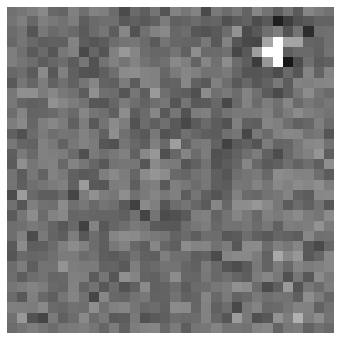

epoch 1 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 40.443398  loss: 29.483944 1 Average Loss: 33.313247 lr 1.0e-04
torch.Size([1])


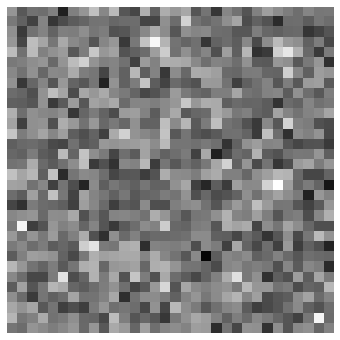

epoch 2 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 27.191271  loss: 26.968132 2 Average Loss: 27.946202 lr 1.0e-04
torch.Size([1])


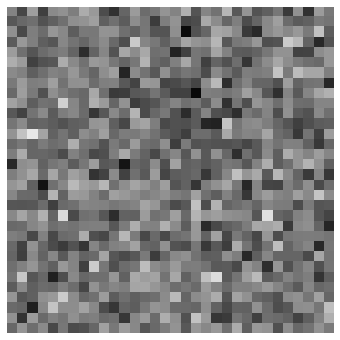

epoch 3 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 26.161348  loss: 26.535252 3 Average Loss: 24.895344 lr 1.0e-04
torch.Size([1])


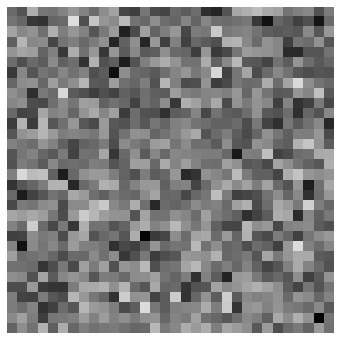

epoch 4 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 26.803425  loss: 22.909840 4 Average Loss: 23.749729 lr 1.0e-04
torch.Size([1])


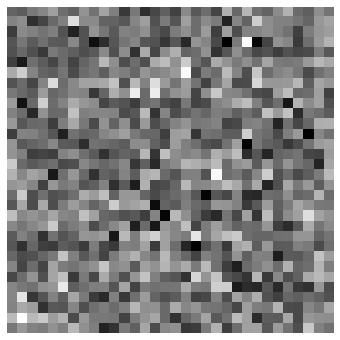

epoch 5 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 24.288244  loss: 23.366234 5 Average Loss: 22.391465 lr 1.0e-04
torch.Size([1])


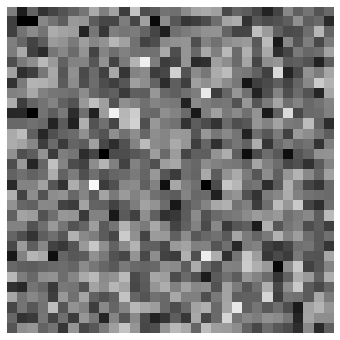

epoch 6 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 21.149698  loss: 24.848904 6 Average Loss: 21.694962 lr 1.0e-04
torch.Size([1])


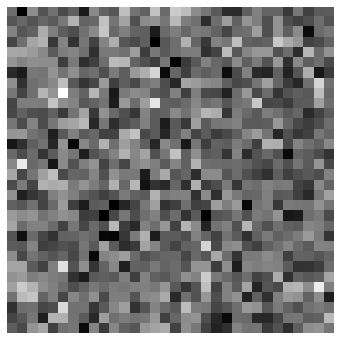

epoch 7 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 20.307640  loss: 20.253738 7 Average Loss: 20.493425 lr 1.0e-04
torch.Size([1])


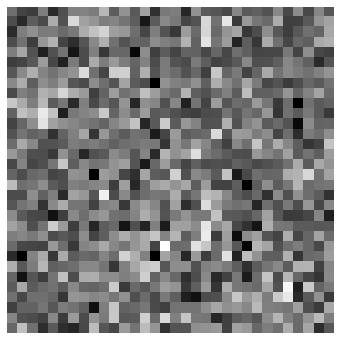

epoch 8 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 17.816973  loss: 18.056734 8 Average Loss: 20.002878 lr 1.0e-04
torch.Size([1])


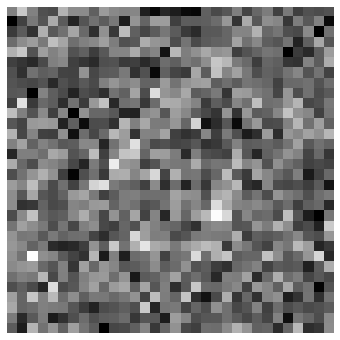

epoch 9 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 21.442287  loss: 19.715549 9 Average Loss: 19.695703 lr 1.0e-04
torch.Size([1])


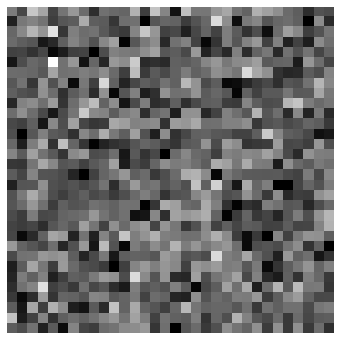

epoch 10 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 19.505342  loss: 18.779194 10 Average Loss: 19.628510 lr 1.0e-04
torch.Size([1])


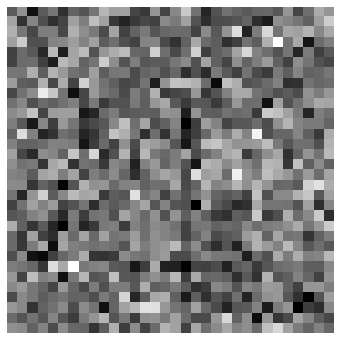

epoch 11 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 19.962559  loss: 21.133196 11 Average Loss: 19.292278 lr 1.0e-04
torch.Size([1])


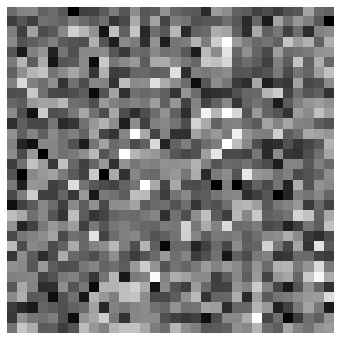

epoch 12 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 21.497137  loss: 18.946270 12 Average Loss: 19.037774 lr 1.0e-04
torch.Size([1])


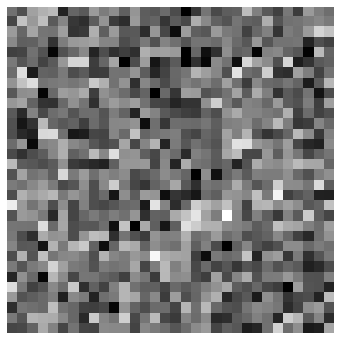

epoch 13 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 17.881187  loss: 19.571419 13 Average Loss: 18.879976 lr 1.0e-04
torch.Size([1])


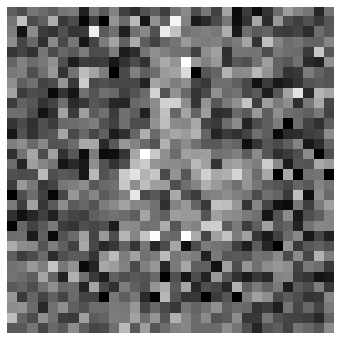

epoch 14 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 17.295504  loss: 19.203094 14 Average Loss: 18.379810 lr 1.0e-04
torch.Size([1])


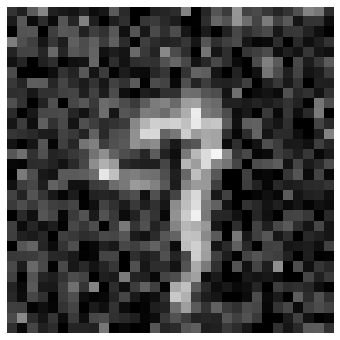

epoch 15 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 18.292618  loss: 18.411160 15 Average Loss: 18.317090 lr 1.0e-04
torch.Size([1])


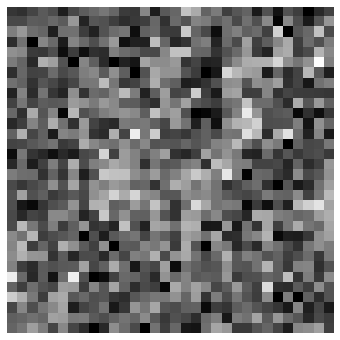

epoch 16 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 20.638111  loss: 19.337177 16 Average Loss: 18.295371 lr 1.0e-04
torch.Size([1])


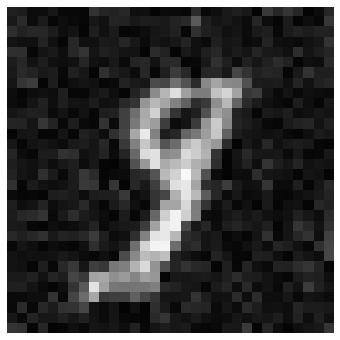

epoch 17 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.970364  loss: 16.501511 17 Average Loss: 17.811492 lr 1.0e-04
torch.Size([1])


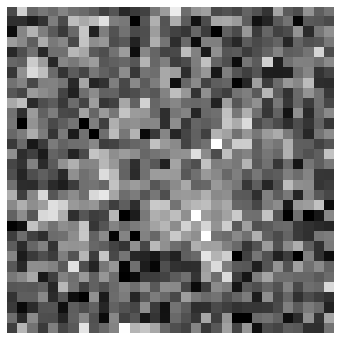

epoch 18 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 18.064751  loss: 17.716347 18 Average Loss: 17.891070 lr 1.0e-04
torch.Size([1])


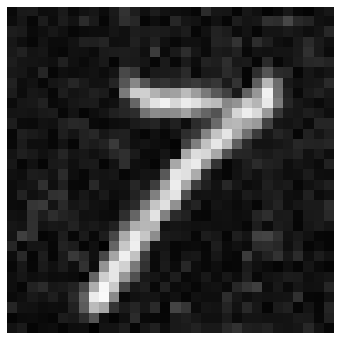

epoch 19 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 18.301563  loss: 17.517422 19 Average Loss: 17.817354 lr 1.0e-04
torch.Size([1])


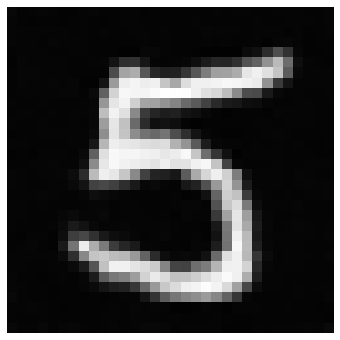

epoch 20 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.942078  loss: 16.473206 20 Average Loss: 17.380440 lr 1.0e-04
torch.Size([1])


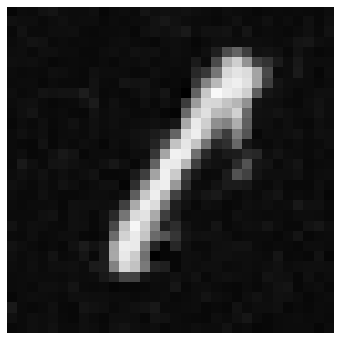

epoch 21 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 18.396917  loss: 17.819105 21 Average Loss: 17.895972 lr 1.0e-04
torch.Size([1])


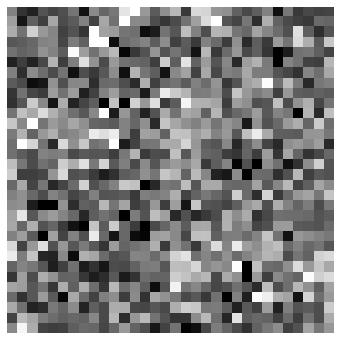

epoch 22 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.730972  loss: 18.388546 22 Average Loss: 17.440301 lr 1.0e-04
torch.Size([1])


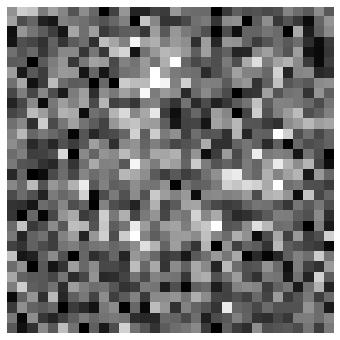

epoch 23 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 19.135830  loss: 17.629951 23 Average Loss: 17.515219 lr 1.0e-04
torch.Size([1])


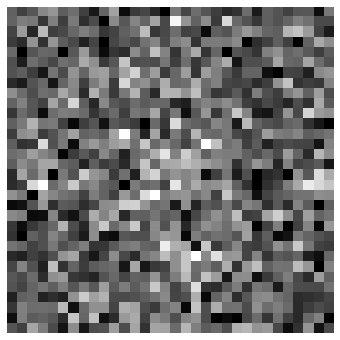

epoch 24 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 17.390934  loss: 19.162054 24 Average Loss: 17.520718 lr 1.0e-04
torch.Size([1])


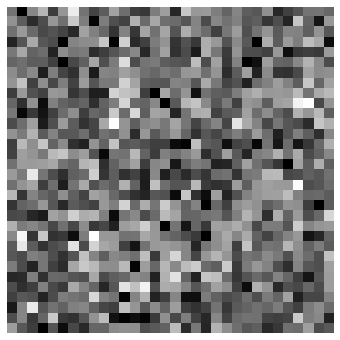

epoch 25 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 18.506907  loss: 17.970856 25 Average Loss: 17.290115 lr 1.0e-04
torch.Size([1])


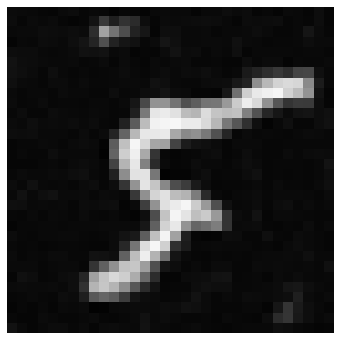

epoch 26 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 17.907242  loss: 18.478504 26 Average Loss: 17.305890 lr 1.0e-04
torch.Size([1])


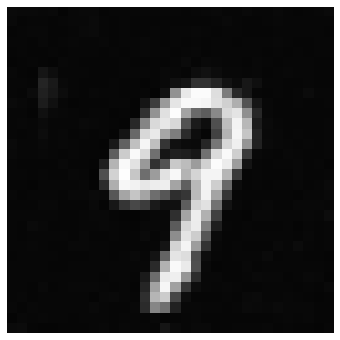

epoch 27 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 18.576927  loss: 17.486965 27 Average Loss: 17.471937 lr 1.0e-04
torch.Size([1])


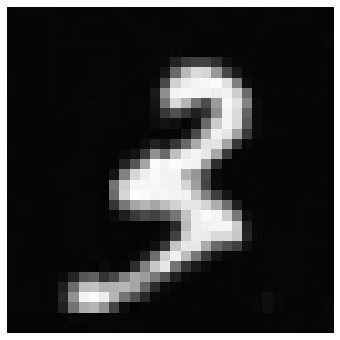

epoch 28 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.948669  loss: 15.935503 28 Average Loss: 16.991268 lr 1.0e-04
torch.Size([1])


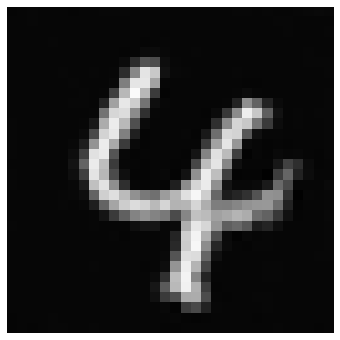

epoch 29 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 18.269363  loss: 16.495686 29 Average Loss: 16.854222 lr 1.0e-04
torch.Size([1])


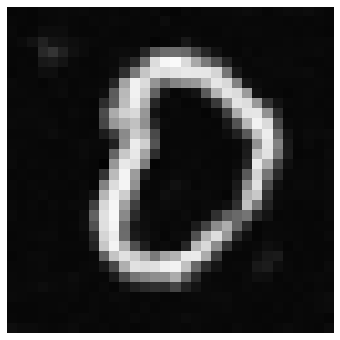

epoch 30 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.436960  loss: 17.005753 30 Average Loss: 16.536808 lr 1.0e-04
torch.Size([1])


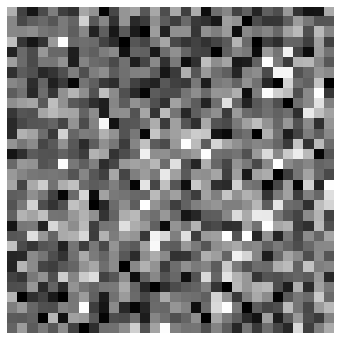

epoch 31 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 17.424862  loss: 18.025135 31 Average Loss: 16.483828 lr 1.0e-04
torch.Size([1])


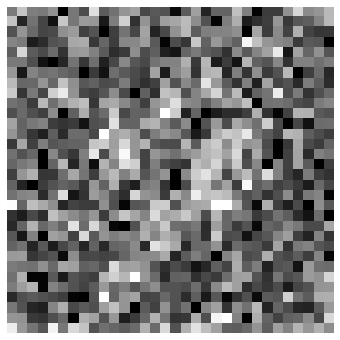

epoch 32 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.216217  loss: 16.222073 32 Average Loss: 16.924641 lr 1.0e-04
torch.Size([1])


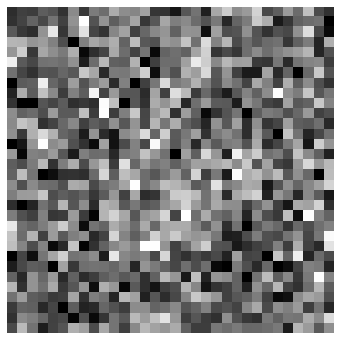

epoch 33 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 17.581139  loss: 16.647610 33 Average Loss: 16.727321 lr 1.0e-04
torch.Size([1])


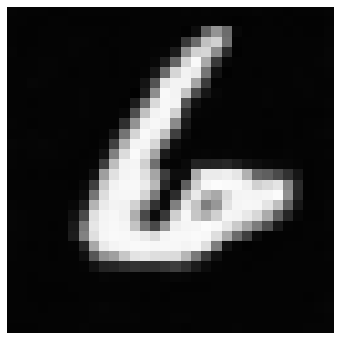

epoch 34 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.852418  loss: 14.081330 34 Average Loss: 16.569867 lr 1.0e-04
torch.Size([1])


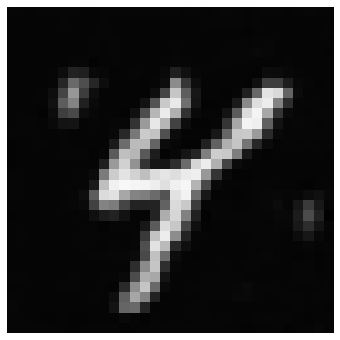

epoch 35 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.984310  loss: 17.566261 35 Average Loss: 16.021773 lr 1.0e-04
torch.Size([1])


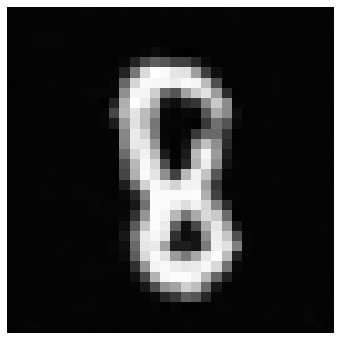

epoch 36 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.500608  loss: 16.472679 36 Average Loss: 16.642924 lr 1.0e-04
torch.Size([1])


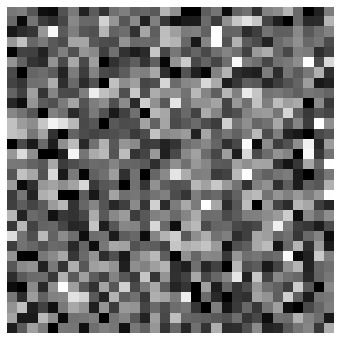

epoch 37 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.697914  loss: 18.211142 37 Average Loss: 16.452926 lr 1.0e-04
torch.Size([1])


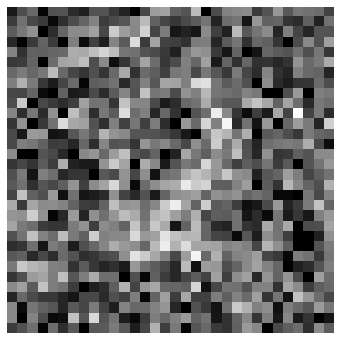

epoch 38 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.960612  loss: 15.928171 38 Average Loss: 16.553183 lr 1.0e-04
torch.Size([1])


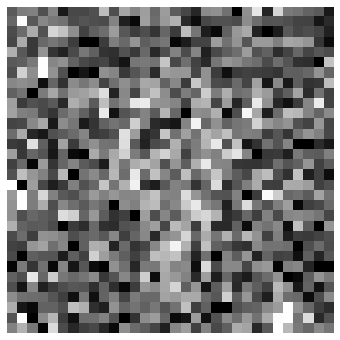

epoch 39 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.702433  loss: 15.011438 39 Average Loss: 16.362181 lr 1.0e-04
torch.Size([1])


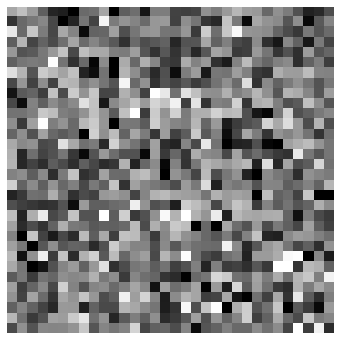

epoch 40 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 18.217575  loss: 17.107941 40 Average Loss: 16.361162 lr 1.0e-04
torch.Size([1])


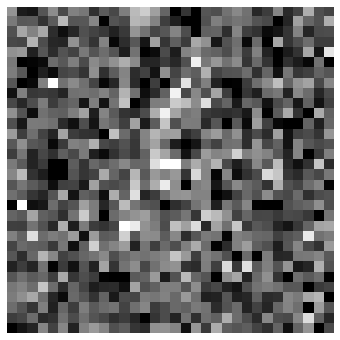

epoch 41 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.663099  loss: 15.447018 41 Average Loss: 16.336077 lr 1.0e-04
torch.Size([1])


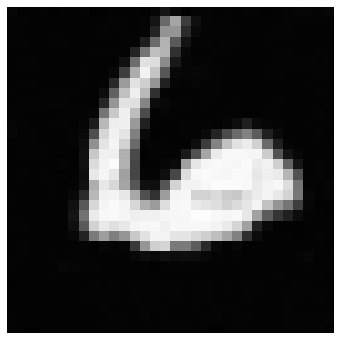

epoch 42 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.372364  loss: 17.165287 42 Average Loss: 16.263863 lr 1.0e-04
torch.Size([1])


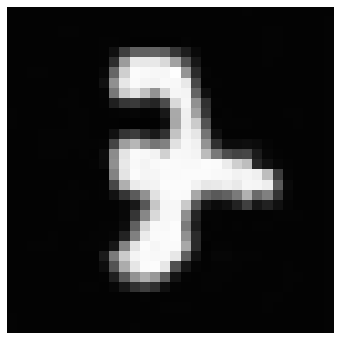

epoch 43 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.314095  loss: 16.719360 43 Average Loss: 16.504126 lr 1.0e-04
torch.Size([1])


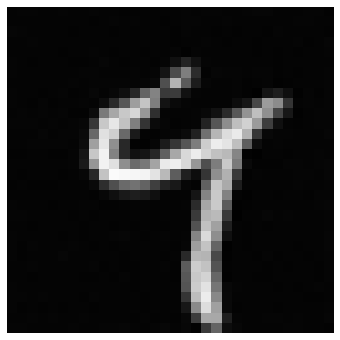

epoch 44 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.951378  loss: 15.946941 44 Average Loss: 16.174434 lr 1.0e-04
torch.Size([1])


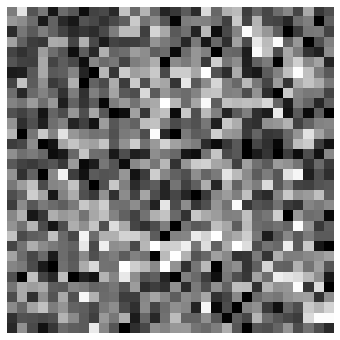

epoch 45 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 17.456013  loss: 17.592781 45 Average Loss: 16.108990 lr 1.0e-04
torch.Size([1])


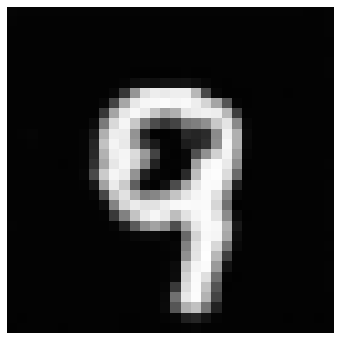

epoch 46 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 17.698589  loss: 16.013603 46 Average Loss: 16.133220 lr 1.0e-04
torch.Size([1])


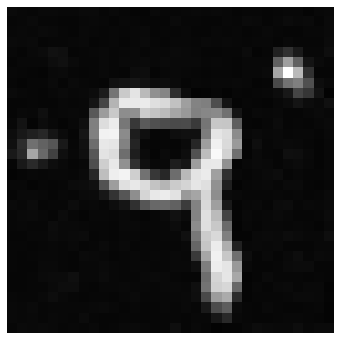

epoch 47 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.099483  loss: 15.274516 47 Average Loss: 16.128307 lr 1.0e-04
torch.Size([1])


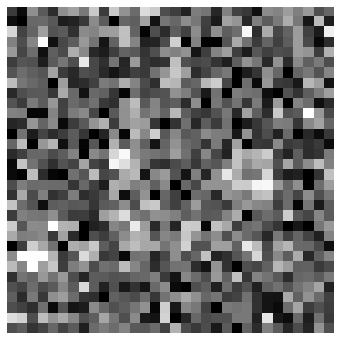

epoch 48 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.588283  loss: 16.045364 48 Average Loss: 16.051593 lr 1.0e-04
torch.Size([1])


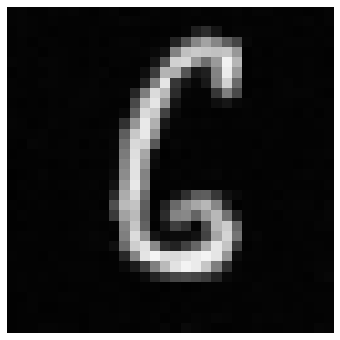

epoch 49 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.458511  loss: 16.290754 49 Average Loss: 15.796281 lr 1.0e-04
torch.Size([1])


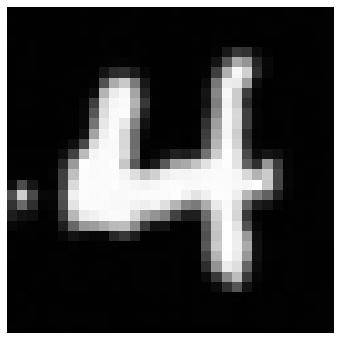

epoch 50 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.209805  loss: 14.947863 50 Average Loss: 15.595371 lr 1.0e-04
torch.Size([1])


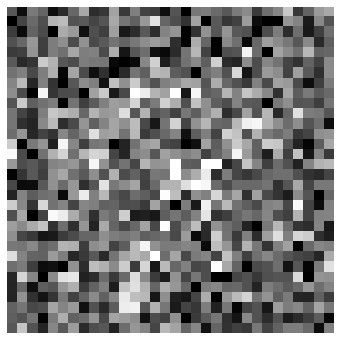

epoch 51 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.390333  loss: 16.138557 51 Average Loss: 16.083472 lr 1.0e-04
torch.Size([1])


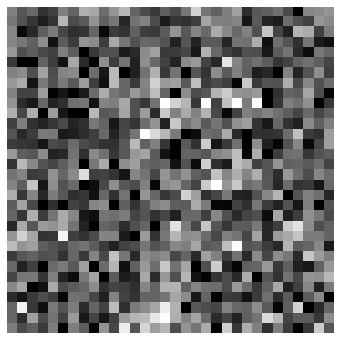

epoch 52 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.913571  loss: 16.552290 52 Average Loss: 16.009411 lr 1.0e-04
torch.Size([1])


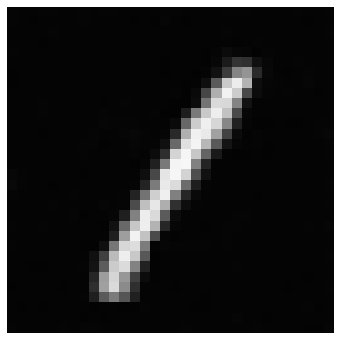

epoch 53 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.068099  loss: 14.974188 53 Average Loss: 15.725297 lr 1.0e-04
torch.Size([1])


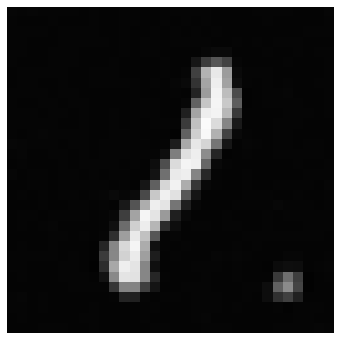

epoch 54 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.992111  loss: 16.829792 54 Average Loss: 15.596767 lr 1.0e-04
torch.Size([1])


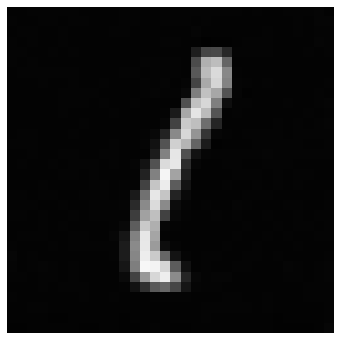

epoch 55 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.981188  loss: 15.699087 55 Average Loss: 15.430577 lr 1.0e-04
torch.Size([1])


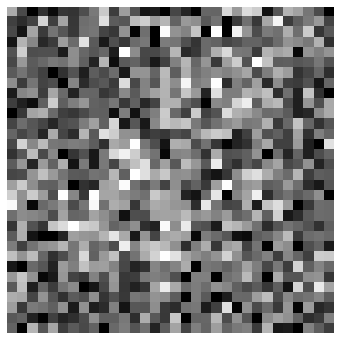

epoch 56 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.264933  loss: 15.378934 56 Average Loss: 15.573476 lr 1.0e-04
torch.Size([1])


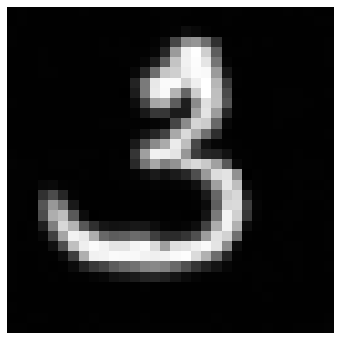

epoch 57 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.525742  loss: 15.483334 57 Average Loss: 15.679796 lr 1.0e-04
torch.Size([1])


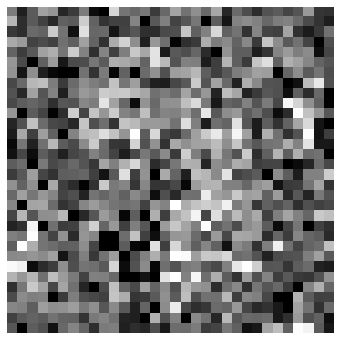

epoch 58 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.816820  loss: 15.245063 58 Average Loss: 15.710665 lr 1.0e-04
torch.Size([1])


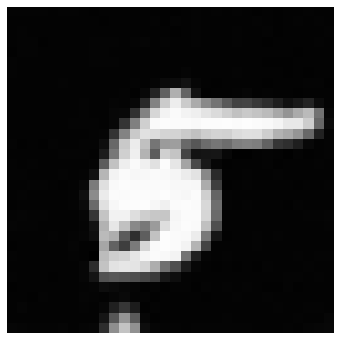

epoch 59 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.037918  loss: 16.224579 59 Average Loss: 16.000607 lr 1.0e-04
torch.Size([1])


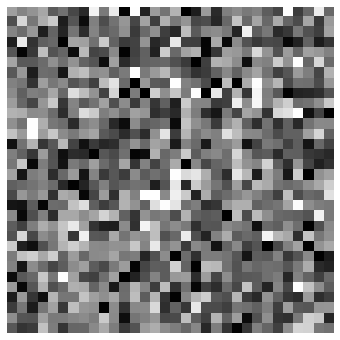

epoch 60 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.099350  loss: 16.225779 60 Average Loss: 15.695406 lr 1.0e-04
torch.Size([1])


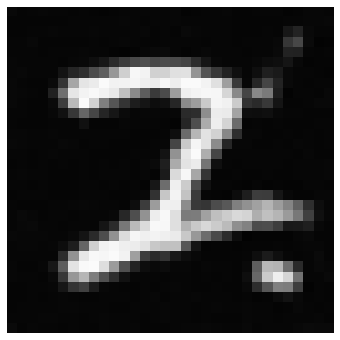

epoch 61 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 17.147545  loss: 16.677120 61 Average Loss: 15.895710 lr 1.0e-04
torch.Size([1])


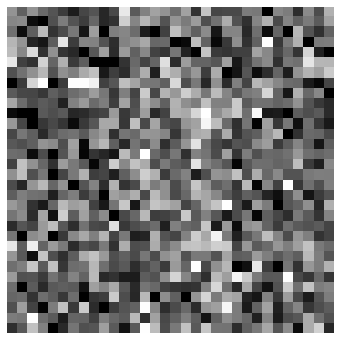

epoch 62 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.263939  loss: 15.790001 62 Average Loss: 15.369969 lr 1.0e-04
torch.Size([1])


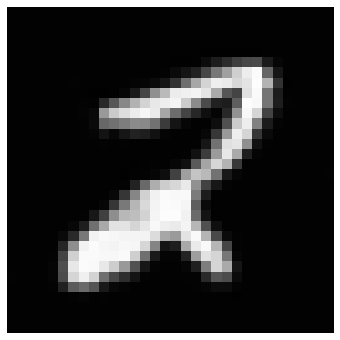

epoch 63 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.623907  loss: 16.694614 63 Average Loss: 15.571103 lr 1.0e-04
torch.Size([1])


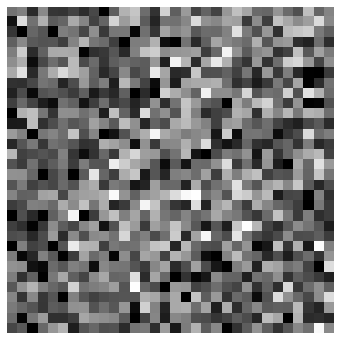

epoch 64 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.963902  loss: 15.923141 64 Average Loss: 15.804945 lr 1.0e-04
torch.Size([1])


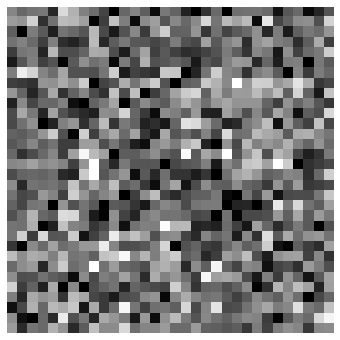

epoch 65 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.032461  loss: 15.415796 65 Average Loss: 15.593620 lr 1.0e-04
torch.Size([1])


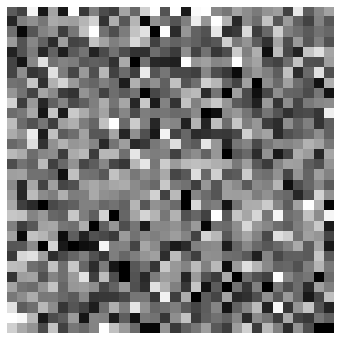

epoch 66 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.329056  loss: 18.108465 66 Average Loss: 15.442607 lr 1.0e-04
torch.Size([1])


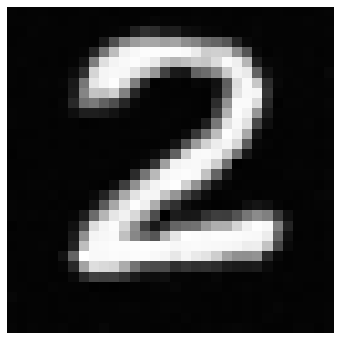

epoch 67 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.414621  loss: 14.960632 67 Average Loss: 15.245742 lr 1.0e-04
torch.Size([1])


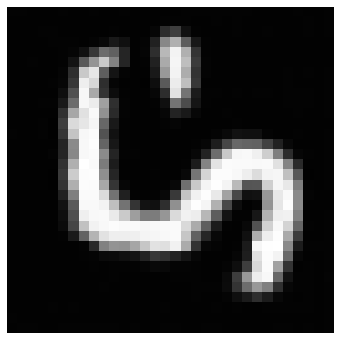

epoch 68 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.287798  loss: 14.012833 68 Average Loss: 15.444889 lr 1.0e-04
torch.Size([1])


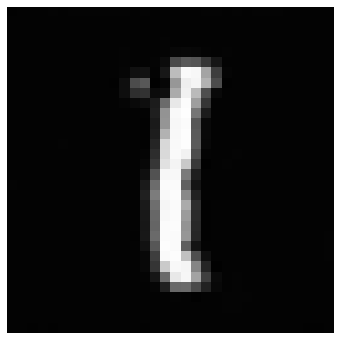

epoch 69 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.181628  loss: 16.620266 69 Average Loss: 15.835754 lr 1.0e-04
torch.Size([1])


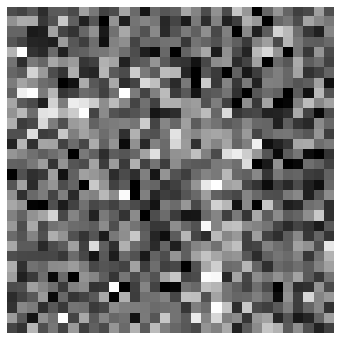

epoch 70 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.981756  loss: 15.315064 70 Average Loss: 15.659441 lr 1.0e-04
torch.Size([1])


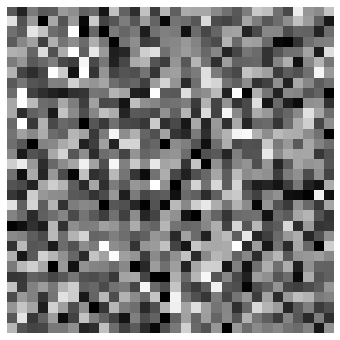

epoch 71 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.438366  loss: 14.400175 71 Average Loss: 15.323347 lr 1.0e-04
torch.Size([1])


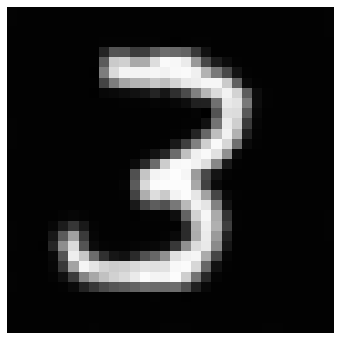

epoch 72 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.963995  loss: 14.087742 72 Average Loss: 15.359714 lr 1.0e-04
torch.Size([1])


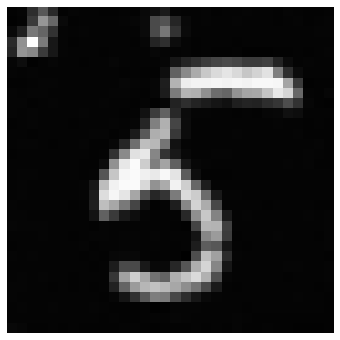

epoch 73 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.790558  loss: 14.506956 73 Average Loss: 15.655956 lr 1.0e-04
torch.Size([1])


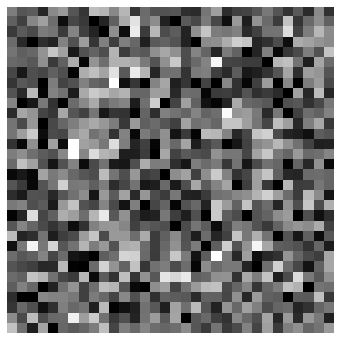

epoch 74 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 13.826360  loss: 17.044830 74 Average Loss: 15.891860 lr 1.0e-04
torch.Size([1])


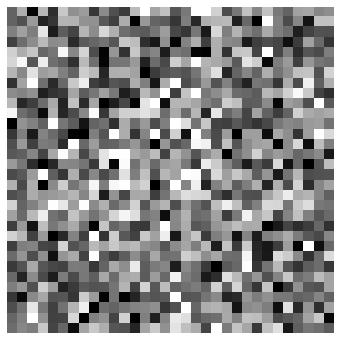

epoch 75 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.253674  loss: 14.624184 75 Average Loss: 15.458487 lr 1.0e-04
torch.Size([1])


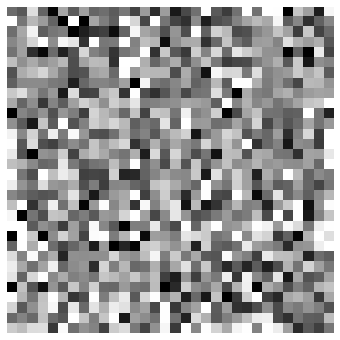

epoch 76 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.245119  loss: 15.666762 76 Average Loss: 15.795443 lr 1.0e-04
torch.Size([1])


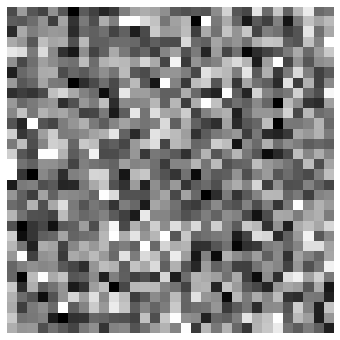

epoch 77 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 18.409830  loss: 15.700880 77 Average Loss: 15.481233 lr 1.0e-04
torch.Size([1])


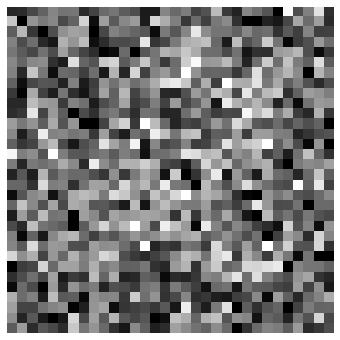

epoch 78 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.916618  loss: 16.741875 78 Average Loss: 15.524520 lr 1.0e-04
torch.Size([1])


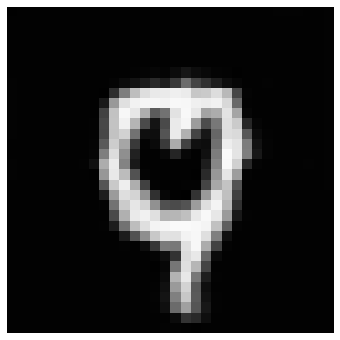

epoch 79 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.543344  loss: 16.967581 79 Average Loss: 15.269847 lr 1.0e-04
torch.Size([1])


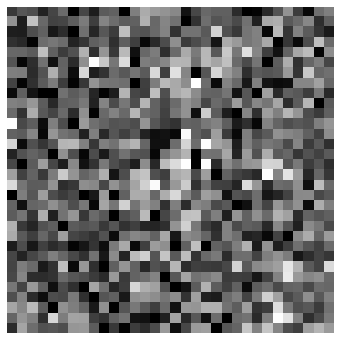

epoch 80 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.679104  loss: 15.276093 80 Average Loss: 15.334334 lr 1.0e-04
torch.Size([1])


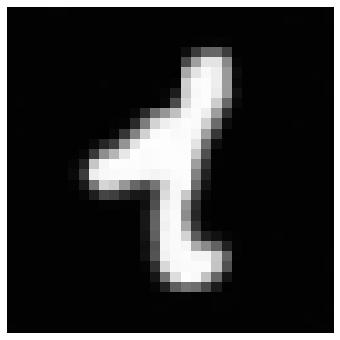

epoch 81 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 13.625160  loss: 14.033745 81 Average Loss: 15.161334 lr 1.0e-04
torch.Size([1])


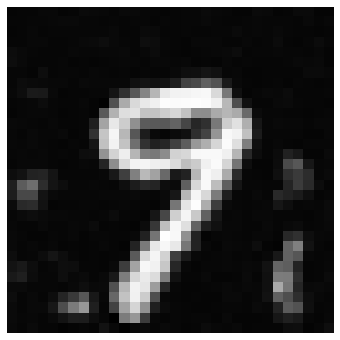

epoch 82 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 13.859804  loss: 14.559540 82 Average Loss: 15.282255 lr 1.0e-04
torch.Size([1])


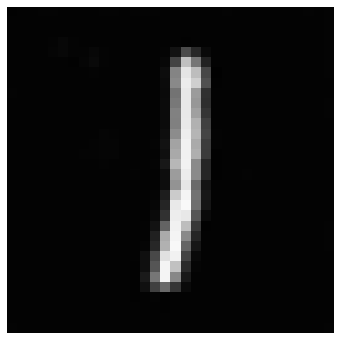

epoch 83 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 13.999826  loss: 16.177967 83 Average Loss: 15.495809 lr 1.0e-04
torch.Size([1])


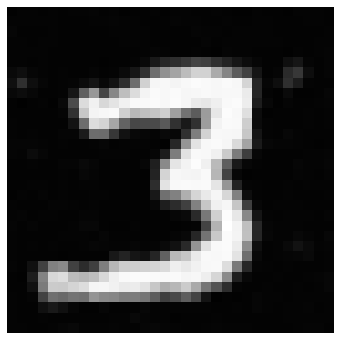

epoch 84 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.982753  loss: 14.120638 84 Average Loss: 15.245223 lr 1.0e-04
torch.Size([1])


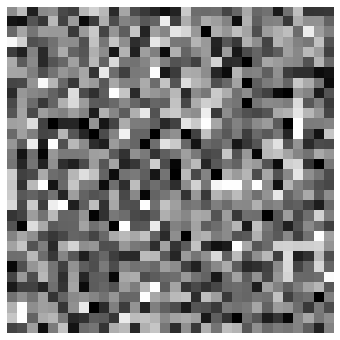

epoch 85 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.077888  loss: 15.272049 85 Average Loss: 15.503671 lr 1.0e-04
torch.Size([1])


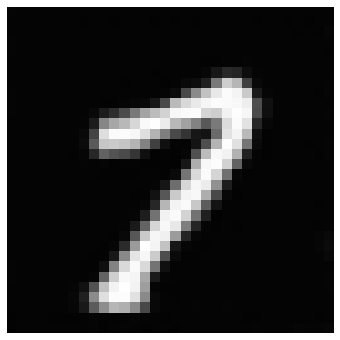

epoch 86 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.728041  loss: 15.699844 86 Average Loss: 15.025148 lr 1.0e-04
torch.Size([1])


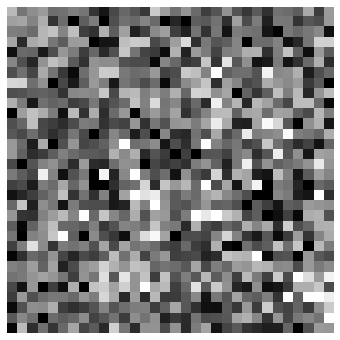

epoch 87 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.982723  loss: 15.490797 87 Average Loss: 15.053635 lr 1.0e-04
torch.Size([1])


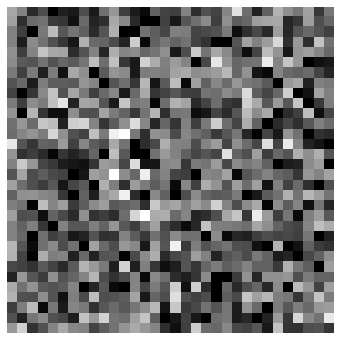

epoch 88 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.191746  loss: 16.833515 88 Average Loss: 15.420373 lr 1.0e-04
torch.Size([1])


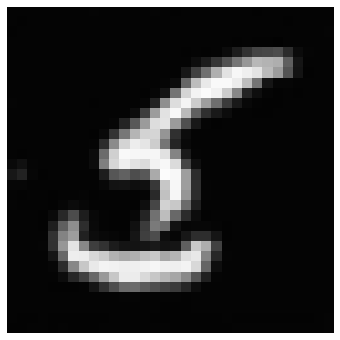

epoch 89 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.772014  loss: 15.288364 89 Average Loss: 15.526516 lr 1.0e-04
torch.Size([1])


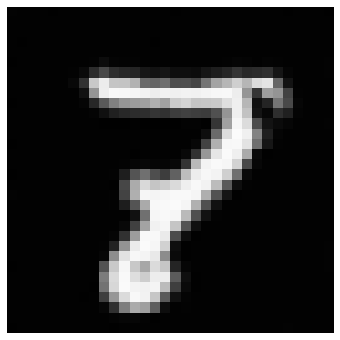

epoch 90 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.180630  loss: 15.988584 90 Average Loss: 15.302239 lr 1.0e-04
torch.Size([1])


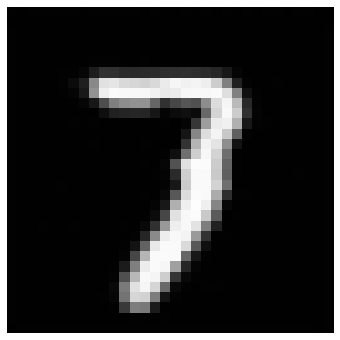

epoch 91 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.042973  loss: 14.200660 91 Average Loss: 15.000273 lr 1.0e-04
torch.Size([1])


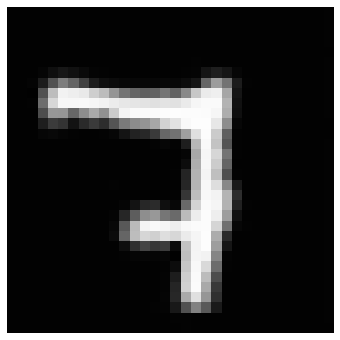

epoch 92 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.525942  loss: 16.944321 92 Average Loss: 15.247777 lr 1.0e-04
torch.Size([1])


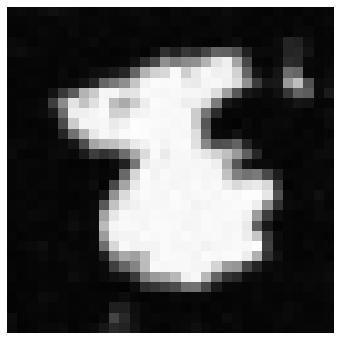

epoch 93 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 17.778927  loss: 15.351446 93 Average Loss: 15.214581 lr 1.0e-04
torch.Size([1])


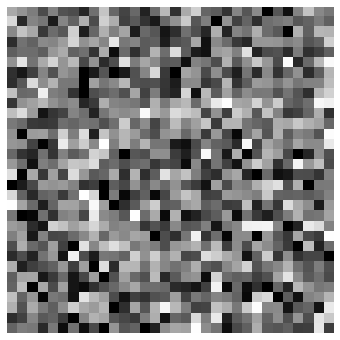

epoch 94 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.146128  loss: 15.367976 94 Average Loss: 14.919586 lr 1.0e-04
torch.Size([1])


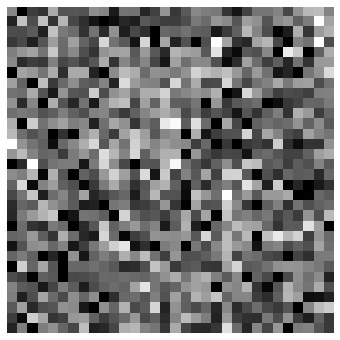

epoch 95 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.832789  loss: 14.486117 95 Average Loss: 14.981538 lr 1.0e-04
torch.Size([1])


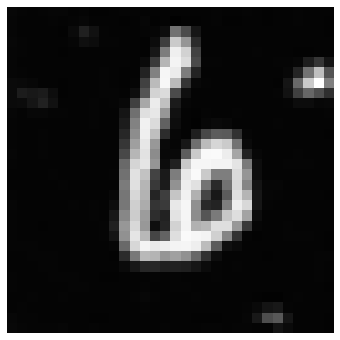

epoch 96 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.268404  loss: 15.869405 96 Average Loss: 15.110690 lr 1.0e-04
torch.Size([1])


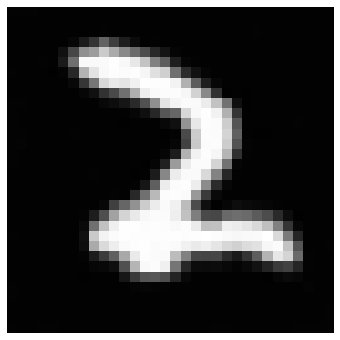

epoch 97 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.488422  loss: 14.798466 97 Average Loss: 15.140579 lr 1.0e-04
torch.Size([1])


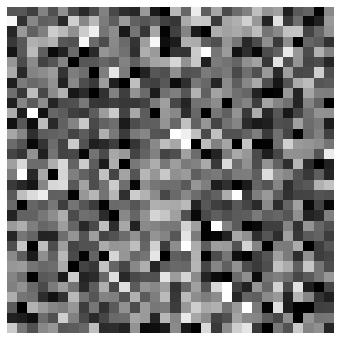

epoch 98 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.907969  loss: 14.826999 98 Average Loss: 15.292139 lr 1.0e-04
torch.Size([1])


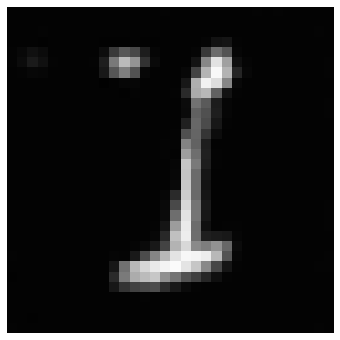

epoch 99 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 13.782366  loss: 15.161776 99 Average Loss: 14.768920 lr 1.0e-04
torch.Size([1])


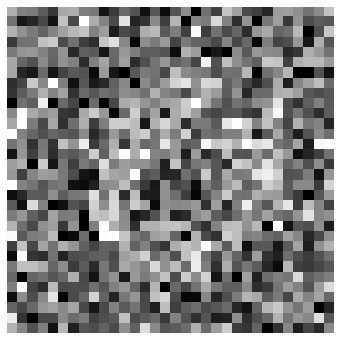

epoch 100 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.138466  loss: 15.064196 100 Average Loss: 14.913785 lr 1.0e-04
torch.Size([1])


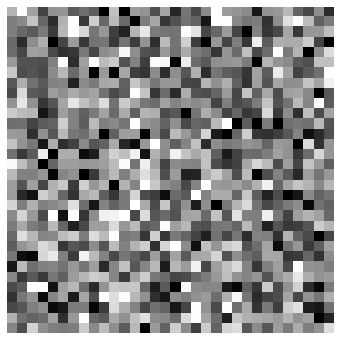

epoch 101 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.015411  loss: 14.651434 101 Average Loss: 14.936430 lr 1.0e-04
torch.Size([1])


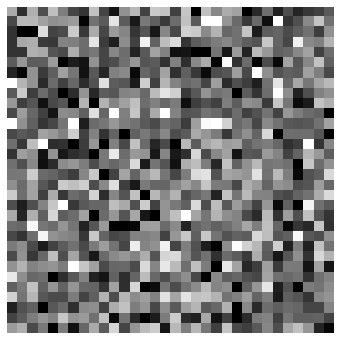

epoch 102 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.835578  loss: 15.176050 102 Average Loss: 15.031509 lr 1.0e-04
torch.Size([1])


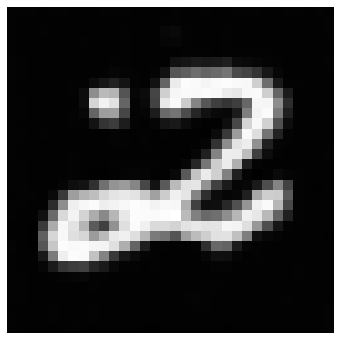

epoch 103 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.313457  loss: 14.326138 103 Average Loss: 15.061908 lr 1.0e-04
torch.Size([1])


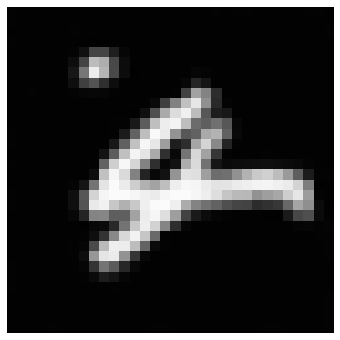

epoch 104 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 13.132175  loss: 14.124808 104 Average Loss: 14.922864 lr 1.0e-04
torch.Size([1])


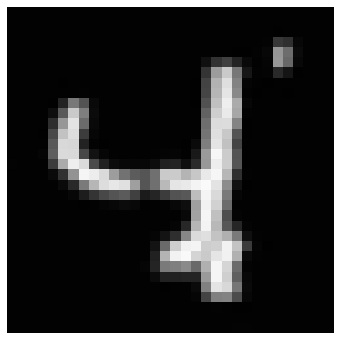

epoch 105 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 13.794788  loss: 13.388844 105 Average Loss: 14.672889 lr 1.0e-04
torch.Size([1])


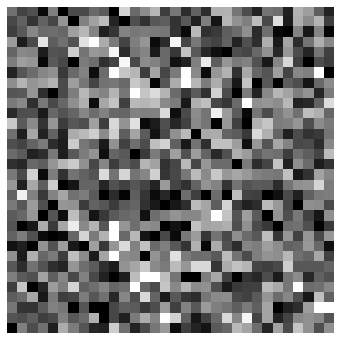

epoch 106 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.755102  loss: 16.653687 106 Average Loss: 14.788514 lr 1.0e-04
torch.Size([1])


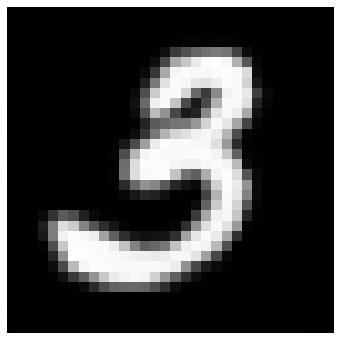

epoch 107 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.111160  loss: 14.628687 107 Average Loss: 15.104458 lr 1.0e-04
torch.Size([1])


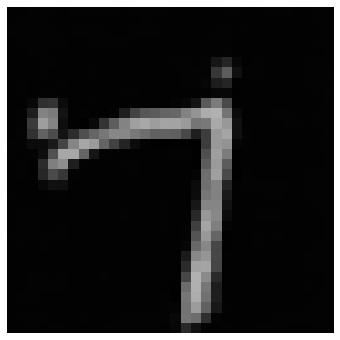

epoch 108 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.747328  loss: 15.518230 108 Average Loss: 14.865976 lr 1.0e-04
torch.Size([1])


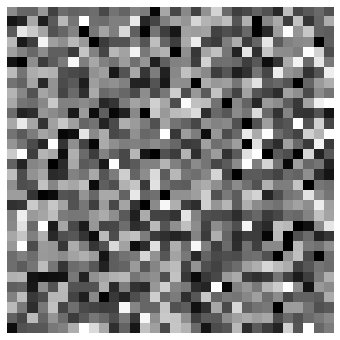

epoch 109 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.319587  loss: 14.124483 109 Average Loss: 14.999321 lr 1.0e-04
torch.Size([1])


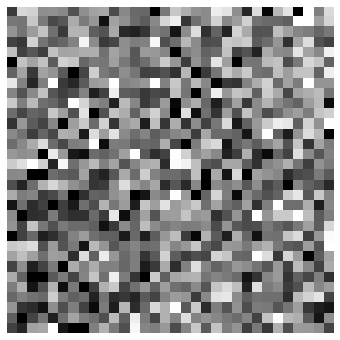

epoch 110 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.703953  loss: 15.254303 110 Average Loss: 15.298619 lr 1.0e-04
torch.Size([1])


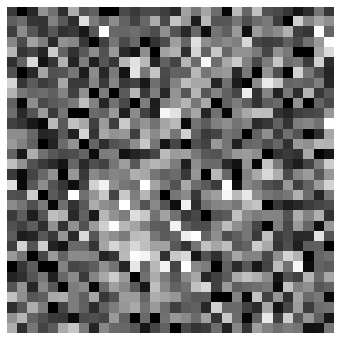

epoch 111 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.651373  loss: 13.705721 111 Average Loss: 15.222831 lr 1.0e-04
torch.Size([1])


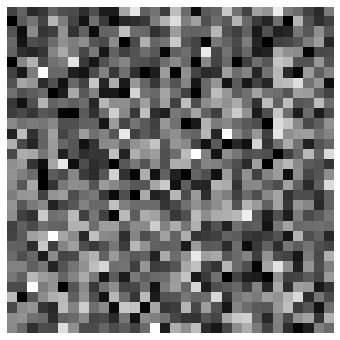

epoch 112 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.462268  loss: 16.342802 112 Average Loss: 15.026051 lr 1.0e-04
torch.Size([1])


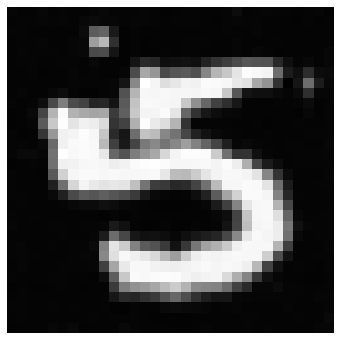

epoch 113 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.660547  loss: 15.623061 113 Average Loss: 15.016132 lr 1.0e-04
torch.Size([1])


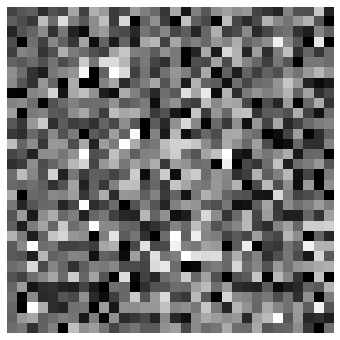

epoch 114 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.707726  loss: 17.273979 114 Average Loss: 15.054810 lr 1.0e-04
torch.Size([1])


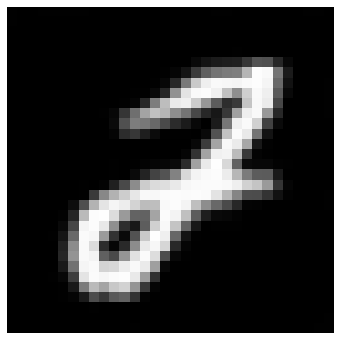

epoch 115 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.926177  loss: 14.835844 115 Average Loss: 14.910168 lr 1.0e-04
torch.Size([1])


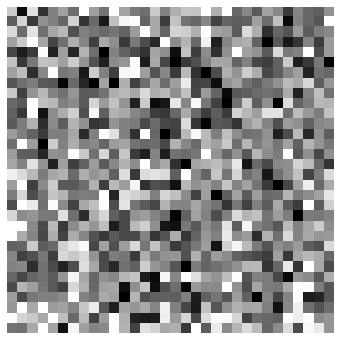

epoch 116 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 17.484262  loss: 15.941781 116 Average Loss: 14.708540 lr 1.0e-04
torch.Size([1])


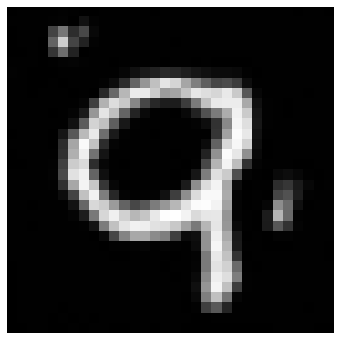

epoch 117 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.807217  loss: 15.577467 117 Average Loss: 14.792606 lr 1.0e-04
torch.Size([1])


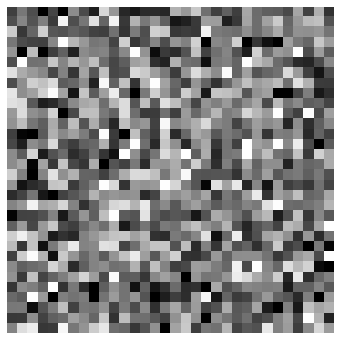

epoch 118 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.174997  loss: 15.395792 118 Average Loss: 15.065244 lr 1.0e-04
torch.Size([1])


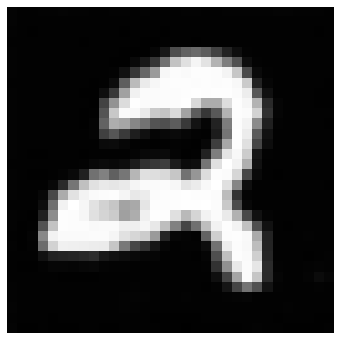

epoch 119 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.237197  loss: 14.016615 119 Average Loss: 15.101703 lr 1.0e-04
torch.Size([1])


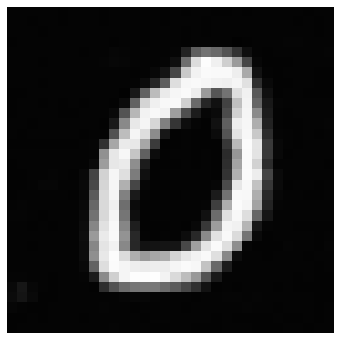

epoch 120 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.057617  loss: 13.909932 120 Average Loss: 14.877132 lr 1.0e-04
torch.Size([1])


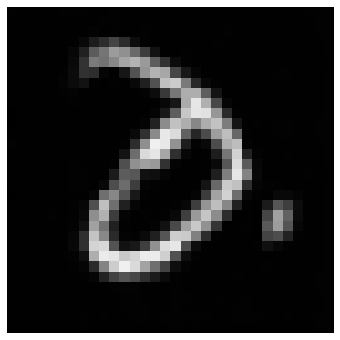

epoch 121 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.216974  loss: 15.587067 121 Average Loss: 15.021045 lr 1.0e-04
torch.Size([1])


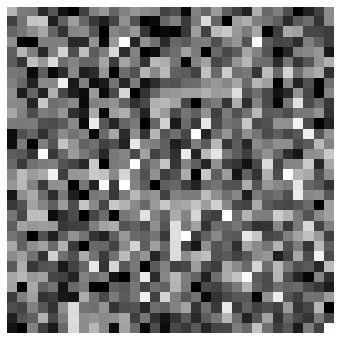

epoch 122 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.392526  loss: 15.870857 122 Average Loss: 14.969323 lr 1.0e-04
torch.Size([1])


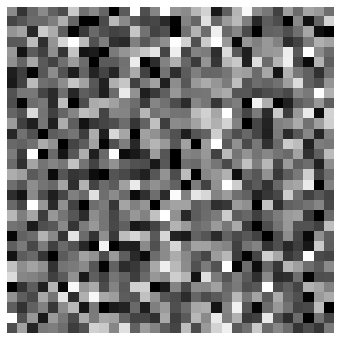

epoch 123 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.032627  loss: 13.297462 123 Average Loss: 14.676517 lr 1.0e-04
torch.Size([1])


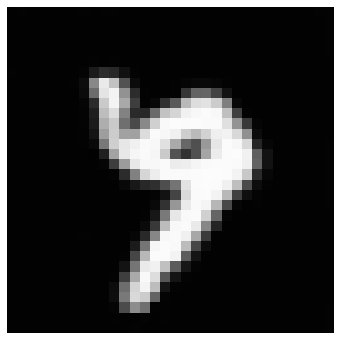

epoch 124 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.148727  loss: 14.129997 124 Average Loss: 14.592755 lr 1.0e-04
torch.Size([1])


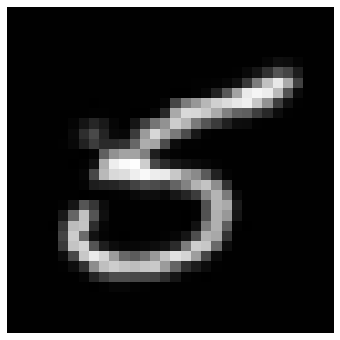

epoch 125 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.627104  loss: 14.404127 125 Average Loss: 14.825678 lr 1.0e-04
torch.Size([1])


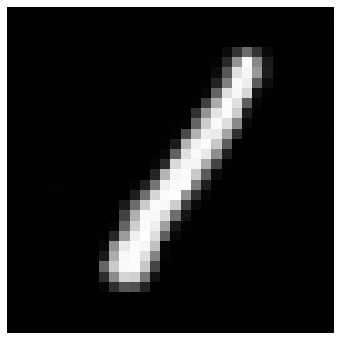

epoch 126 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.146185  loss: 13.907475 126 Average Loss: 15.025065 lr 1.0e-04
torch.Size([1])


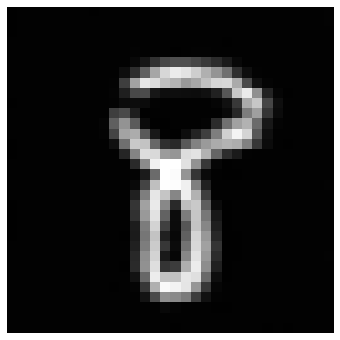

epoch 127 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 13.971732  loss: 14.459132 127 Average Loss: 14.851433 lr 1.0e-04
torch.Size([1])


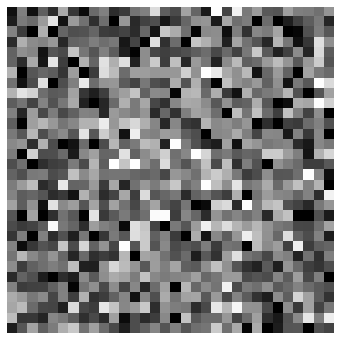

epoch 128 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.900879  loss: 14.191975 128 Average Loss: 14.799729 lr 1.0e-04
torch.Size([1])


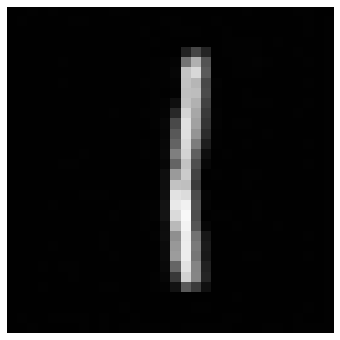

epoch 129 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.070068  loss: 16.024879 129 Average Loss: 14.639913 lr 1.0e-04
torch.Size([1])


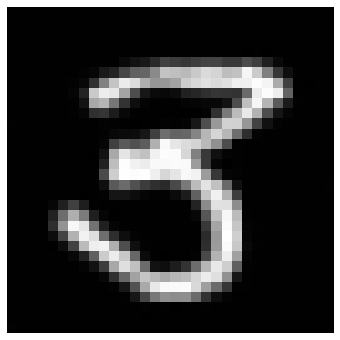

epoch 130 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.846630  loss: 14.743097 130 Average Loss: 14.709690 lr 1.0e-04
torch.Size([1])


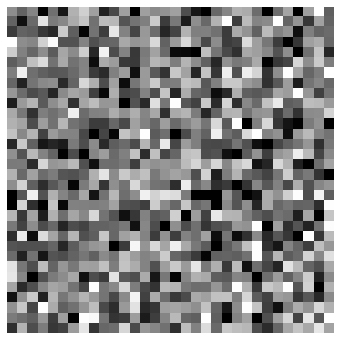

epoch 131 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.845451  loss: 15.365157 131 Average Loss: 14.812368 lr 1.0e-04
torch.Size([1])


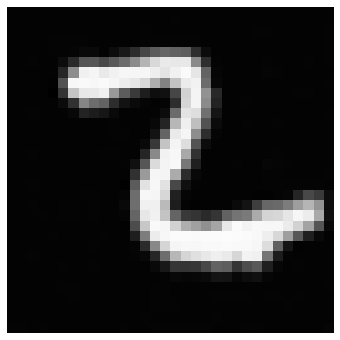

epoch 132 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.785385  loss: 14.647837 132 Average Loss: 14.789776 lr 1.0e-04
torch.Size([1])


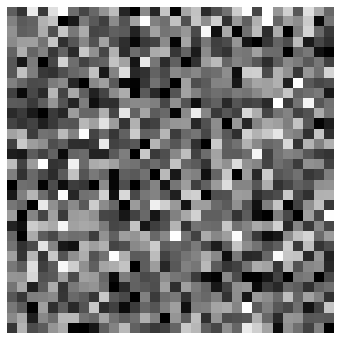

epoch 133 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.125292  loss: 13.027849 133 Average Loss: 14.568611 lr 1.0e-04
torch.Size([1])


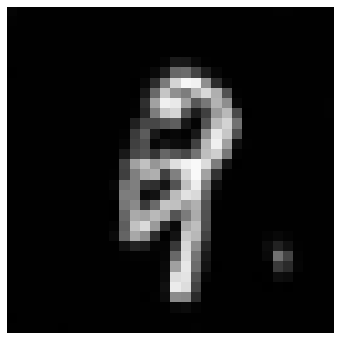

epoch 134 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.490994  loss: 15.366226 134 Average Loss: 14.994520 lr 1.0e-04
torch.Size([1])


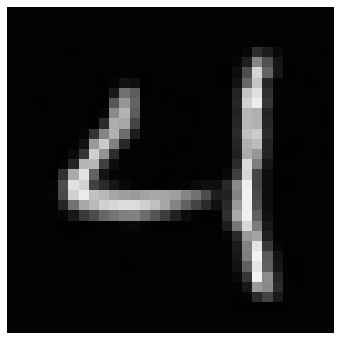

epoch 135 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.736433  loss: 15.597927 135 Average Loss: 14.857579 lr 1.0e-04
torch.Size([1])


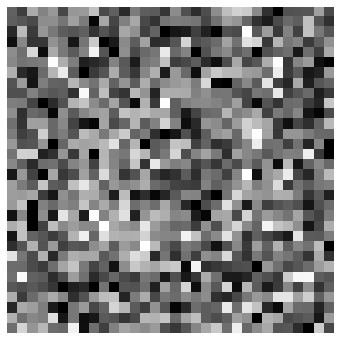

epoch 136 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 13.884300  loss: 17.066477 136 Average Loss: 14.559191 lr 1.0e-04
torch.Size([1])


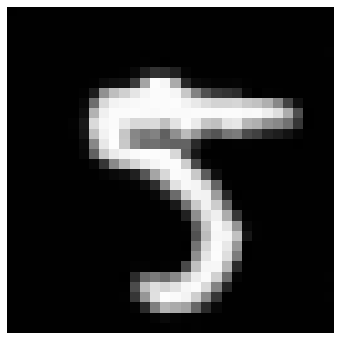

epoch 137 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 13.128074  loss: 13.335981 137 Average Loss: 14.441979 lr 1.0e-04
torch.Size([1])


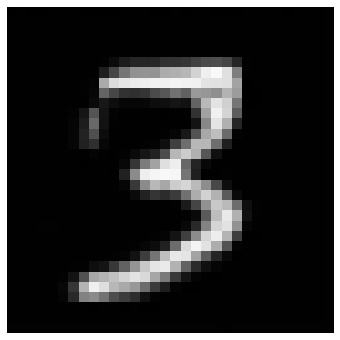

epoch 138 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.446104  loss: 13.650473 138 Average Loss: 14.587451 lr 1.0e-04
torch.Size([1])


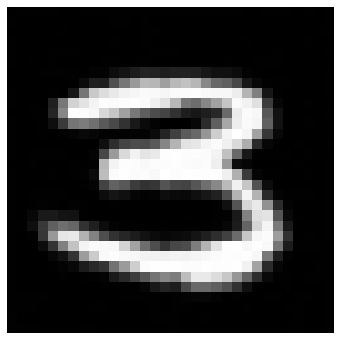

epoch 139 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.144794  loss: 13.580923 139 Average Loss: 14.520179 lr 1.0e-04
torch.Size([1])


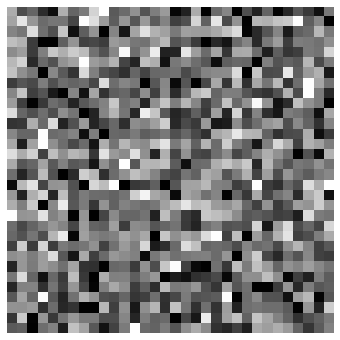

epoch 140 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.550081  loss: 13.060120 140 Average Loss: 14.637183 lr 1.0e-04
torch.Size([1])


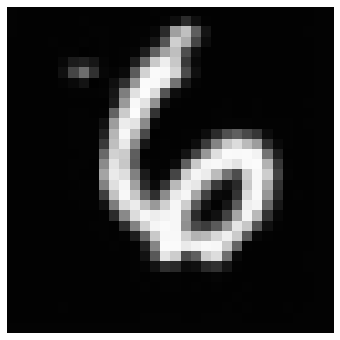

epoch 141 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.512598  loss: 15.014991 141 Average Loss: 14.769759 lr 1.0e-04
torch.Size([1])


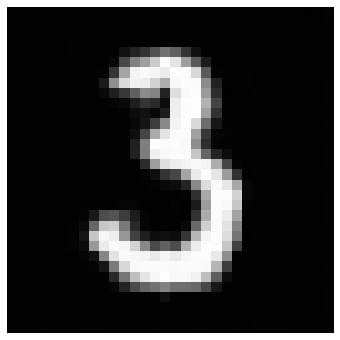

epoch 142 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.302588  loss: 14.616682 142 Average Loss: 14.416619 lr 1.0e-04
torch.Size([1])


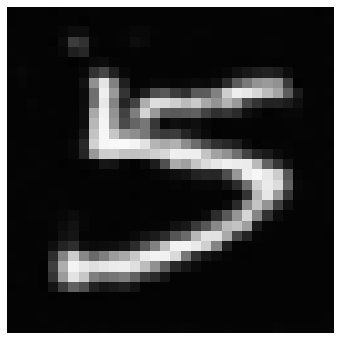

epoch 143 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.766364  loss: 15.827669 143 Average Loss: 14.820080 lr 1.0e-04
torch.Size([1])


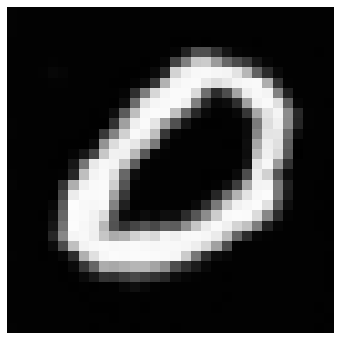

epoch 144 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 13.854753  loss: 16.320795 144 Average Loss: 14.720522 lr 1.0e-04
torch.Size([1])


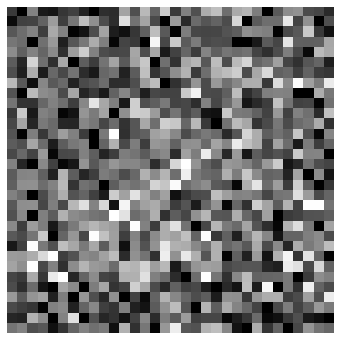

epoch 145 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 13.746018  loss: 14.894594 145 Average Loss: 14.727191 lr 1.0e-04
torch.Size([1])


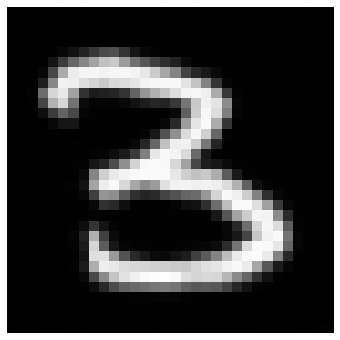

epoch 146 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.166306  loss: 13.556589 146 Average Loss: 14.615483 lr 1.0e-04
torch.Size([1])


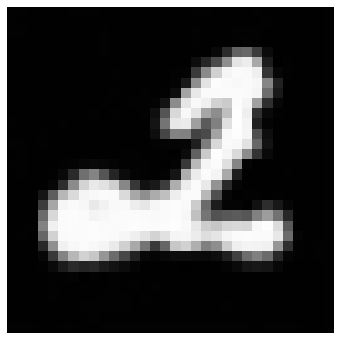

epoch 147 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.823477  loss: 14.157986 147 Average Loss: 14.895593 lr 1.0e-04
torch.Size([1])


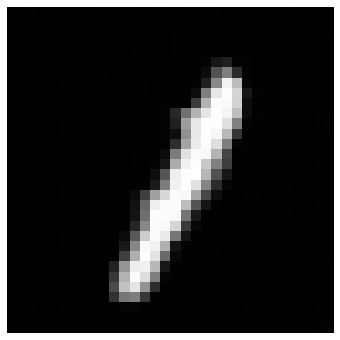

epoch 148 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.967561  loss: 15.034963 148 Average Loss: 14.905974 lr 1.0e-04
torch.Size([1])


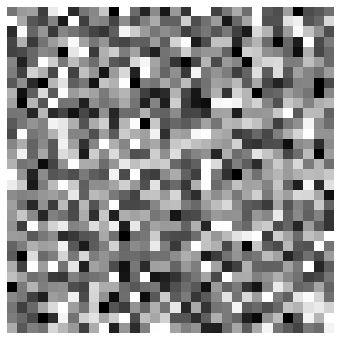

epoch 149 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 13.514523  loss: 15.312840 149 Average Loss: 14.798830 lr 1.0e-04
torch.Size([1])


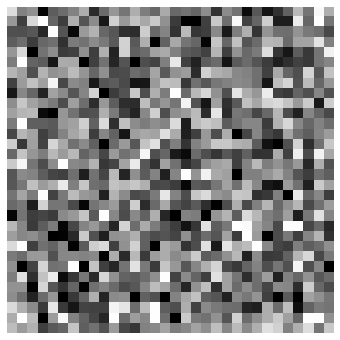

epoch 150 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.919178  loss: 15.876842 150 Average Loss: 14.451298 lr 1.0e-04
torch.Size([1])


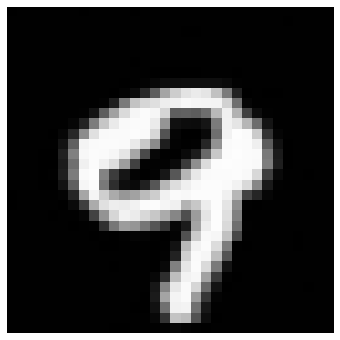

epoch 151 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.488339  loss: 15.849255 151 Average Loss: 14.389181 lr 1.0e-04
torch.Size([1])


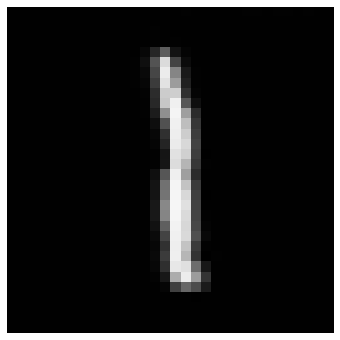

epoch 152 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.794875  loss: 13.424028 152 Average Loss: 14.297955 lr 1.0e-04
torch.Size([1])


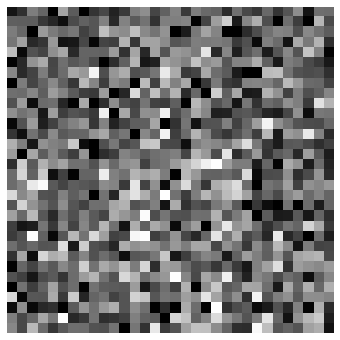

epoch 153 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 13.051607  loss: 14.260281 153 Average Loss: 14.562911 lr 1.0e-04
torch.Size([1])


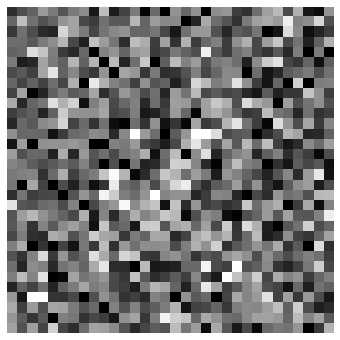

epoch 154 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 13.237326  loss: 15.510204 154 Average Loss: 14.610297 lr 1.0e-04
torch.Size([1])


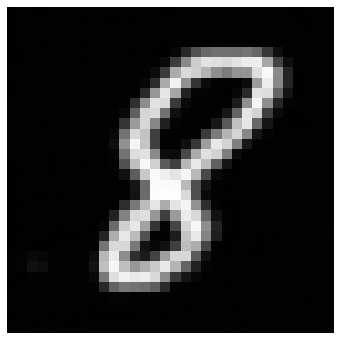

epoch 155 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.298711  loss: 15.705596 155 Average Loss: 14.682432 lr 1.0e-04
torch.Size([1])


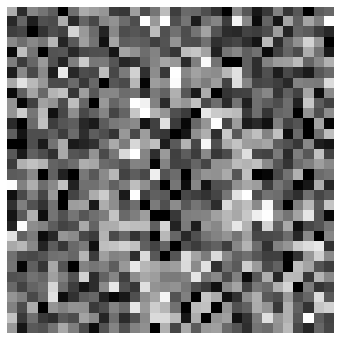

epoch 156 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 13.701368  loss: 13.728582 156 Average Loss: 14.334220 lr 1.0e-04
torch.Size([1])


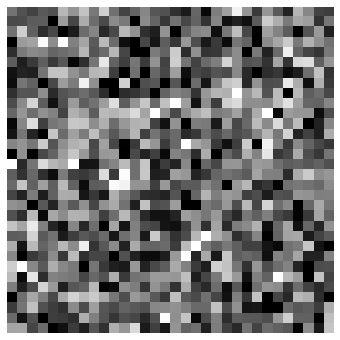

epoch 157 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.184637  loss: 13.553321 157 Average Loss: 14.427583 lr 1.0e-04
torch.Size([1])


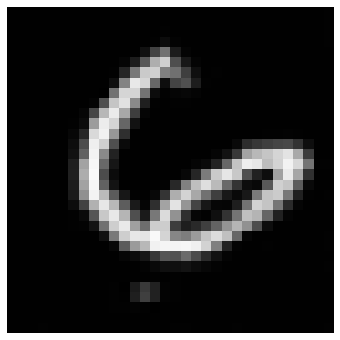

epoch 158 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 13.769486  loss: 14.784262 158 Average Loss: 14.253557 lr 1.0e-04
torch.Size([1])


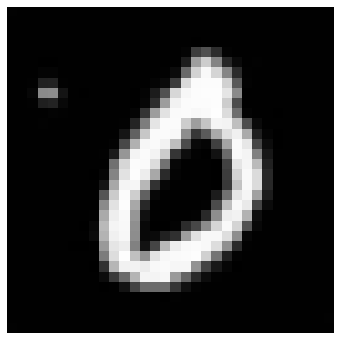

epoch 159 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 13.395998  loss: 14.830632 159 Average Loss: 14.903049 lr 1.0e-04
torch.Size([1])


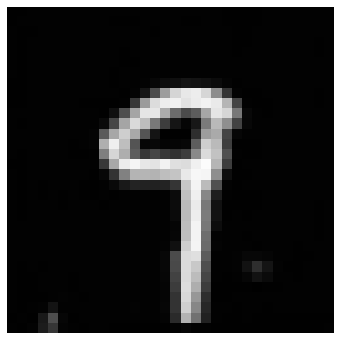

epoch 160 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.179287  loss: 15.982736 160 Average Loss: 14.731266 lr 1.0e-04
torch.Size([1])


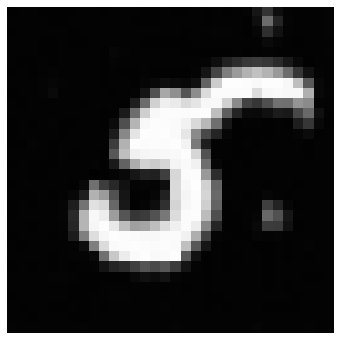

epoch 161 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.111079  loss: 13.527704 161 Average Loss: 14.363765 lr 1.0e-04
torch.Size([1])


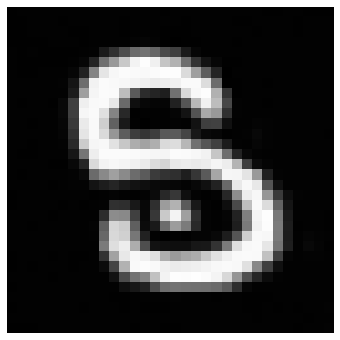

epoch 162 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.654308  loss: 14.268405 162 Average Loss: 14.371545 lr 1.0e-04
torch.Size([1])


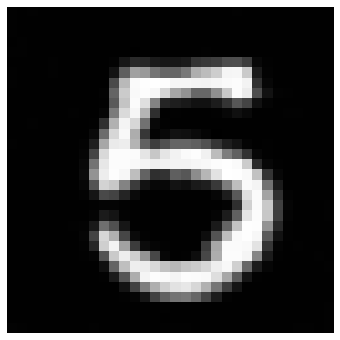

epoch 163 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.514198  loss: 14.415102 163 Average Loss: 14.234380 lr 1.0e-04
torch.Size([1])


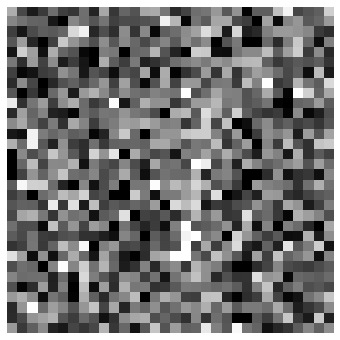

epoch 164 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.224832  loss: 15.219110 164 Average Loss: 14.350892 lr 1.0e-04
torch.Size([1])


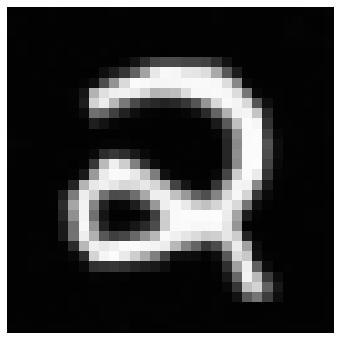

epoch 165 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.405791  loss: 15.302610 165 Average Loss: 14.524460 lr 1.0e-04
torch.Size([1])


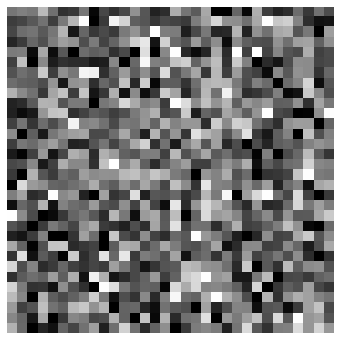

epoch 166 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.182114  loss: 14.852917 166 Average Loss: 14.864154 lr 1.0e-04
torch.Size([1])


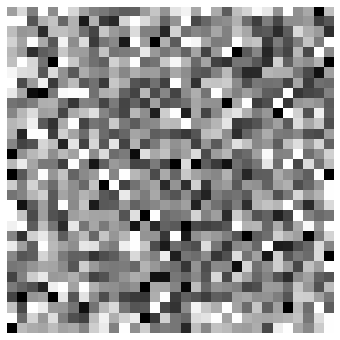

epoch 167 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.970513  loss: 15.507389 167 Average Loss: 14.509530 lr 1.0e-04
torch.Size([1])


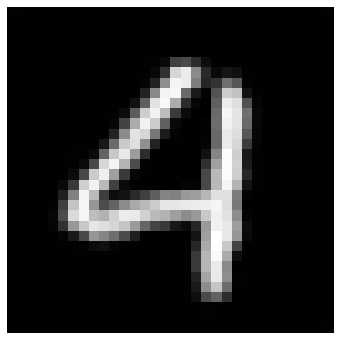

epoch 168 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.829386  loss: 15.280940 168 Average Loss: 14.514190 lr 1.0e-04
torch.Size([1])


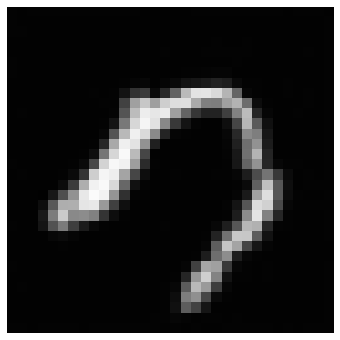

epoch 169 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.542960  loss: 14.477770 169 Average Loss: 14.276223 lr 1.0e-04
torch.Size([1])


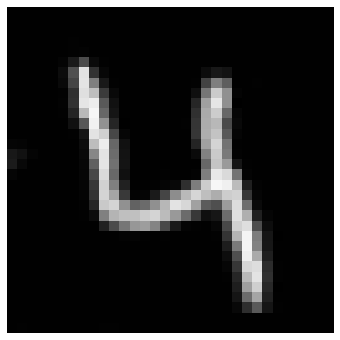

epoch 170 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.197510  loss: 15.997934 170 Average Loss: 14.684471 lr 1.0e-04
torch.Size([1])


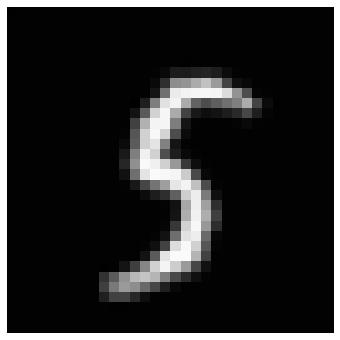

epoch 171 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.883951  loss: 14.782295 171 Average Loss: 14.712283 lr 1.0e-04
torch.Size([1])


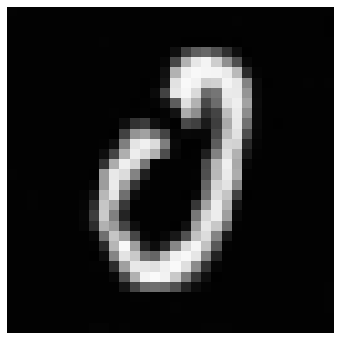

epoch 172 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.756199  loss: 15.059920 172 Average Loss: 14.487253 lr 1.0e-04
torch.Size([1])


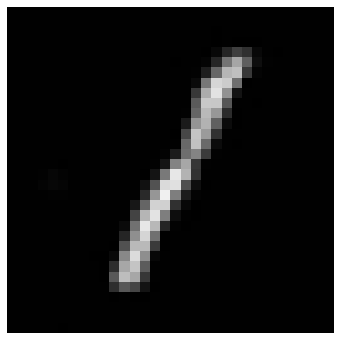

epoch 173 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 13.879398  loss: 14.109316 173 Average Loss: 14.692445 lr 1.0e-04
torch.Size([1])


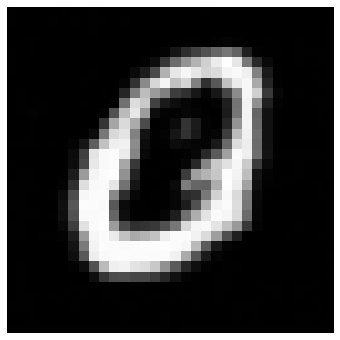

epoch 174 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 13.596888  loss: 14.700306 174 Average Loss: 14.639789 lr 1.0e-04
torch.Size([1])


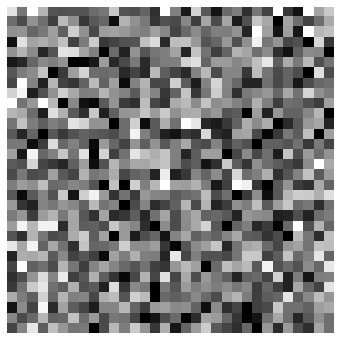

epoch 175 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.220449  loss: 14.621007 175 Average Loss: 14.739880 lr 1.0e-04
torch.Size([1])


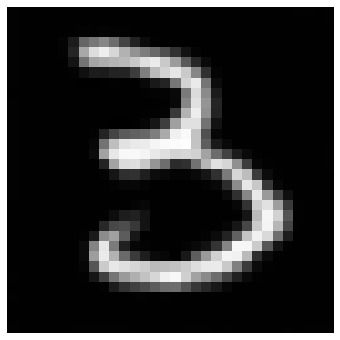

epoch 176 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.250439  loss: 15.534235 176 Average Loss: 14.470560 lr 1.0e-04
torch.Size([1])


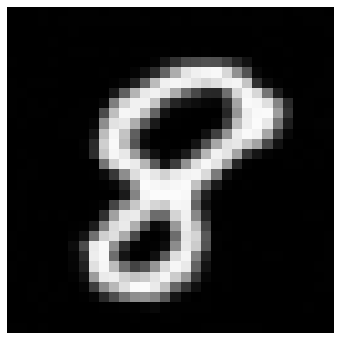

epoch 177 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.658003 178 Average Loss: 14.568465 lr 1.0e-04
torch.Size([1])


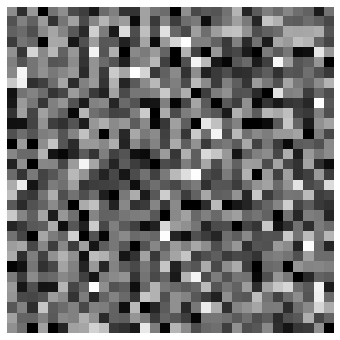

epoch 179 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.025386  loss: 15.695283 179 Average Loss: 14.703199 lr 1.0e-04
torch.Size([1])


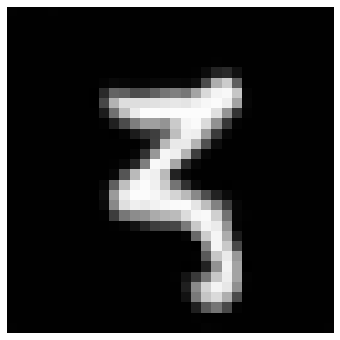

epoch 180 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.217444  loss: 14.258764 180 Average Loss: 14.331645 lr 1.0e-04
torch.Size([1])


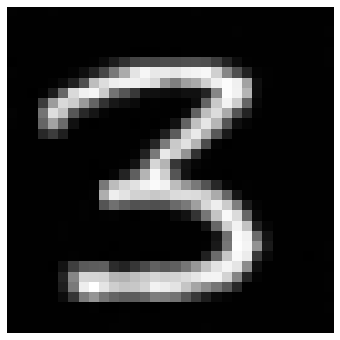

epoch 181 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.228153  loss: 14.249019 181 Average Loss: 14.200762 lr 1.0e-04
torch.Size([1])


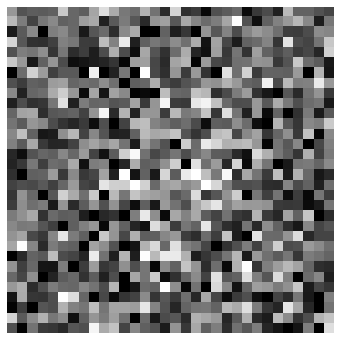

epoch 182 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.515361  loss: 14.248260 182 Average Loss: 14.175009 lr 1.0e-04
torch.Size([1])


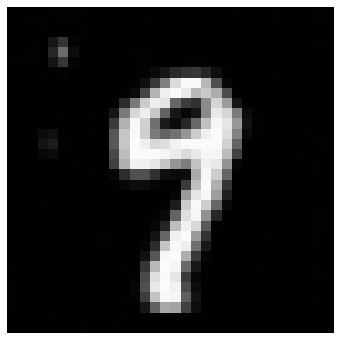

epoch 183 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.946572  loss: 15.273772 183 Average Loss: 14.168945 lr 1.0e-04
torch.Size([1])


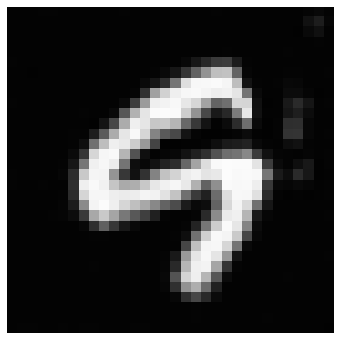

epoch 184 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.638678  loss: 13.920568 184 Average Loss: 14.526406 lr 1.0e-04
torch.Size([1])


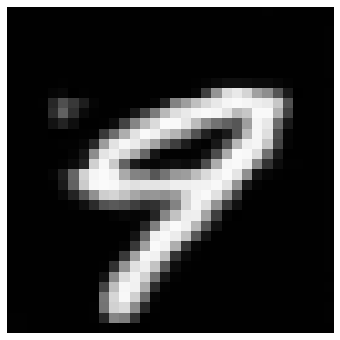

epoch 185 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 13.288580  loss: 13.852121 185 Average Loss: 14.247439 lr 1.0e-04
torch.Size([1])


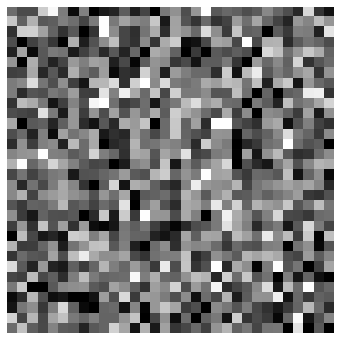

epoch 186 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.132457  loss: 15.488487 186 Average Loss: 14.147321 lr 1.0e-04
torch.Size([1])


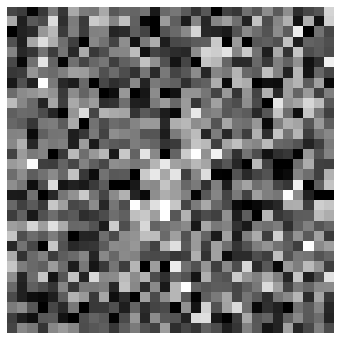

epoch 187 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 13.654308  loss: 14.936735 187 Average Loss: 14.627130 lr 1.0e-04
torch.Size([1])


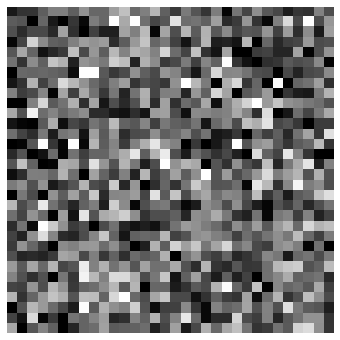

epoch 188 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.489631  loss: 14.774466 188 Average Loss: 14.468433 lr 1.0e-04
torch.Size([1])


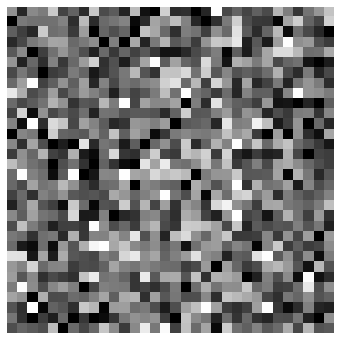

epoch 189 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 13.660410  loss: 14.295296 189 Average Loss: 14.649857 lr 1.0e-04
torch.Size([1])


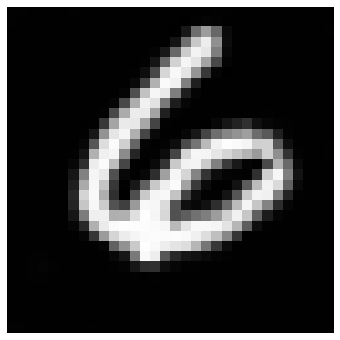

epoch 190 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.632299  loss: 14.338429 190 Average Loss: 14.387465 lr 1.0e-04
torch.Size([1])
 loss: 13.794458 191 Average Loss: 14.224633 lr 1.0e-04
torch.Size([1])


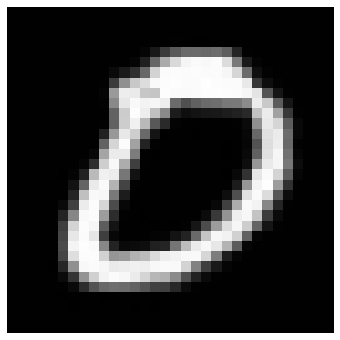

epoch 192 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 13.813823  loss: 15.826794 192 Average Loss: 14.247220 lr 1.0e-04
torch.Size([1])


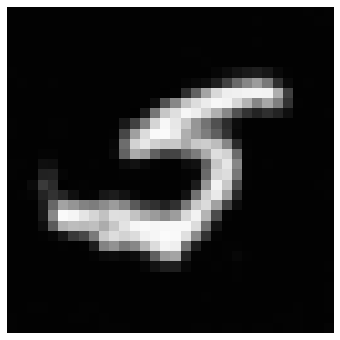

epoch 193 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.223568  loss: 15.136696 193 Average Loss: 14.245989 lr 1.0e-04
torch.Size([1])


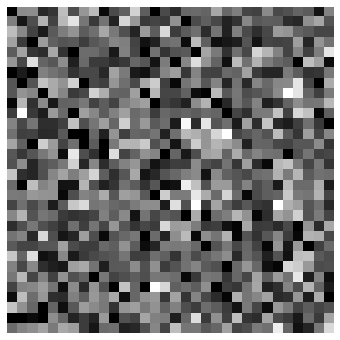

epoch 194 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 16.459379  loss: 14.987603 194 Average Loss: 14.754472 lr 1.0e-04
torch.Size([1])


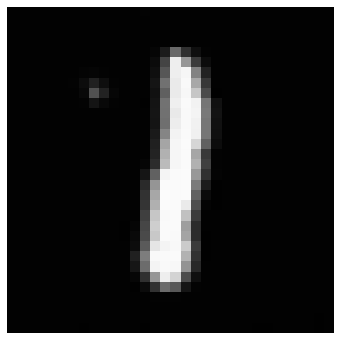

epoch 195 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.269463  loss: 15.017525 195 Average Loss: 14.577498 lr 1.0e-04
torch.Size([1])


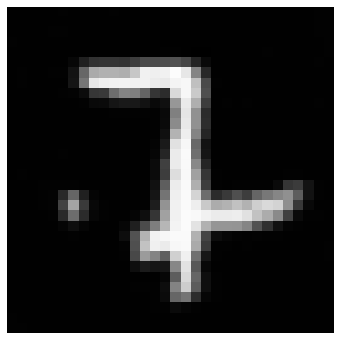

epoch 196 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 12.657808  loss: 16.150978 196 Average Loss: 14.220353 lr 1.0e-04
torch.Size([1])


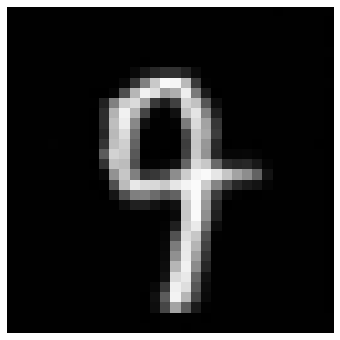

epoch 197 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.050842  loss: 13.875240 197 Average Loss: 14.351763 lr 1.0e-04
torch.Size([1])


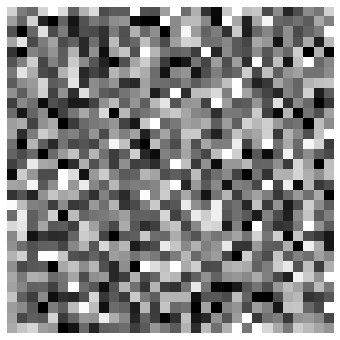

epoch 198 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 14.768517  loss: 14.349635 198 Average Loss: 14.411185 lr 1.0e-04
torch.Size([1])


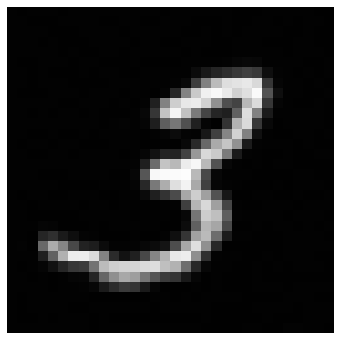

epoch 199 

  0%|          | 0/118 [00:00<?, ?it/s]

 loss: 15.075207  loss: 15.121427 199 Average Loss: 14.547845 lr 1.0e-04
torch.Size([1])


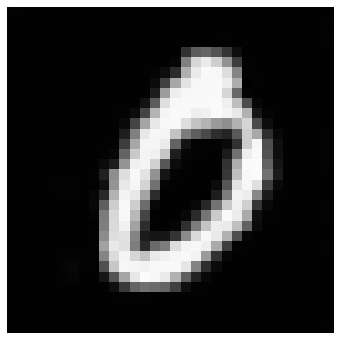

In [14]:
###### device = torch.device('cuda')
# Feel free to play with hyperparameters for training!
# score_model = torch.nn.DataParallel(model_arch)
# score_model = score_model.to(device)
# train_diffusion_model(dataset, score_model,
#                       n_epochs =   200,
#                       batch_size =  96,
#                       lr=10e-3,
#                       model_name=model_name)
model.train(model_arch, dataset,resume_training=False,ema=True, 
            leanrning_rate=0.0001,vlb_need=False, epoches=200,print_step=100,
            batch_size=512,snapshot_freq=5000, log_path=model_name)

In [18]:
import math
# def visualize_digit_embedding(digit_embed):
#     cossim_mat = []
#     for i in range(10):
#         cossim = torch.cosine_similarity(digit_embed, digit_embed[i:i+1,:]).cpu()
#         cossim_mat.append(cossim)
#     cossim_mat = torch.stack(cossim_mat)
#     cossim_mat_nodiag = cossim_mat + torch.diag_embed(math.nan * torch.ones(10))
#     plt.imshow(cossim_mat_nodiag)
#     plt.show()
#     return cossim_mat

In [ ]:
model.visual_process(model_arch,torch.tensor(0).to('cuda'), timesteps=6)

torch.Size([1])


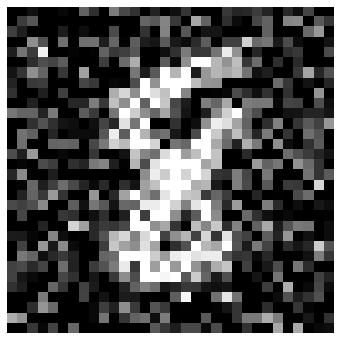

In [46]:
model.visual_process(model_arch,torch.tensor(8).to('cuda'),
                     sample_type="ddpm_noisy", timesteps=5)

In [ ]:
# def save_samples_cond(score_model, suffix):
#   score_model.eval()
#   for digit in range(10):
#     ## Generate samples using the specified sampler.
#     sample_batch_size = 64 #@param {'type':'integer'}
#     num_steps = 500 #@param {'type':'integer'}
#     sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
#     # score_model.eval()
#     ## Generate samples using the specified sampler.
#     samples = sampler(score_model, 
#             marginal_prob_std_fn,
#             diffusion_coeff_fn, 
#             sample_batch_size, 
#             num_steps=num_steps,
#             device=device,
#             y=digit*torch.ones(sample_batch_size, dtype=torch.long))

#         ## Sample visualization.
#     samples = samples.clamp(0.0, 1.0)
#     sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))
#     sample_np = sample_grid.permute(1, 2, 0).cpu().numpy()
#     plt.imsave(f"condition_diffusion{suffix}_digit%d.png"%digit, sample_np,)
#     plt.figure(figsize=(6,6))
#     plt.axis('off')
#     plt.imshow(sample_np, vmin=0., vmax=1.)
#     plt.show()


In [ ]:
def save_samples_cond(score_model, model_name, suffix,image_shape):
    score_model.eval()
    for digit in range(10):
        ## Generate samples using the specified sampler.
        sample_batch_size = 64 #@param {'type':'integer'}
        num_steps = 500 #@param {'type':'integer'}
        sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
        # score_model.eval()
        ## Generate samples using the specified sampler.
        samples = sampler(score_model, 
            marginal_prob_std_fn,
            diffusion_coeff_fn, 
            sample_batch_size, 
            num_steps=num_steps,
                     x_shape=image_shape,     
            device=device,
            y=digit*torch.ones(sample_batch_size, dtype=torch.long))

        ## Sample visualization.
        samples = samples.clamp(0.0, 1.0)
        sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))
        sample_np = sample_grid.permute(1, 2, 0).cpu().numpy()
        if not os.path.exists(os.path.join("img",model_name)):
            os.makedirs(os.path.join("img", model_name))
        image_file = os.path.join("img", model_name, f"condition_diffusion{suffix}_digit%d.png"%digit)
        plt.imsave(image_file, sample_np,)
        plt.figure(figsize=(6,6))
        plt.axis('off')
        plt.imshow(sample_np, vmin=0., vmax=1.)
        plt.show()

In [ ]:
save_samples_cond(score_model,model_name,"_head1",image_shape) # model with res connection